## Imports & Constants

In [2]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from numba import njit
from tqdm import tqdm
import time
import multiprocessing
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import seaborn as sns
#'''
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
#'''
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{lmodern} \boldmath'  # Use Latin Modern and enable bold math
#plt.rcParams['font.family'] = 'Times New Roman'

#Constants
G = 6.6743e-11 #Gravitational Constant in S.I. Units
c = 2.99792458e8  #Speed of light in m/s
Ms = 1.9891e+30 #Mass of the Sun in kg
alpha = (2*G)/(c**2) #Redefining 2G/c^2 as \alpha
a0 = 0.1 #arbitrary value
r_core = 1e-20 #Staring value for the radius

#Initial Conditions
V0 = 2*a0*r_core
H0 = a0*(r_core**2)
M0 = 4*np.pi*(r_core**3)/3
print(V0,H0, M0)

2e-21 1e-41 4.1887902047863904e-60


## Functions for file loading

In [6]:
'''
#Importing data from EOS tables
def EOS_load(file_name):
    cols = ['Baryon_Density','Pressure','Energy_Density']
    df = pd.read_csv(file_name,sep='\t',names=cols)
    kgm = 1e3
    fctr = c**2
    P = df.Pressure.values * kgm * fctr
    rho = df.Energy_Density.values * kgm
    # Remove decreasing pressure points
    mask = np.concatenate(([True], P[1:] >= P[:-1]))
    P = P[mask]
    rho = rho[mask]
    return P, rho

data = np.genfromtxt(f"{source_dir}eos_{eos_name}.txt", delimiter=None)
    baryon_density = data[:, 1]
    density = data[:, 2]
    pressure = data[:, 3]
'''
# Importing data from EOS tables (new format)
def EOS_load(file_name):
    # Load space-separated values (no headers)
    data = np.genfromtxt(file_name, delimiter=None)

    baryon_density = data[:, 1]  # Second column
    rho = data[:, 2] * 1e3  # Third column, convert units to SI
    P = data[:, 3] * 0.1  # Fourth column, convert units to SI

    # Remove decreasing pressure points
    mask = np.concatenate(([True], P[1:] >= P[:-1]))
    P = P[mask]
    rho = rho[mask]

    return P, rho


#Converting data to log
def convert_log(P, rho):
    P_log = np.log(P)
    rho_log = np.log(rho)
    return P_log, rho_log

## TOV and other functions

In [7]:
@njit(fastmath=True)
#TOV Equations
def dpdr(P,M,rho,r):
    pbyr = -((G*M*rho)/(r**2)) * ( 1 + ( P/( rho*(c**2) ) ) ) * ( 1 + (4*np.pi*(r**3)*P)/(M*(c**2)) ) * ( (1 - (2*G*M)/(r*(c**2))) **(-1) )
    return pbyr

@njit(fastmath=True)
#Function that returns dm/dr
def dmdr(r,rho):

    mbyr = 4*np.pi*(r**2)*rho
    return mbyr

#Differential equations involved in calculating the tidal love number 
def dVdr(H0,V0,m,r,P,rho):
    derv = num_der(1e-5,rho,P)
    z = ( 1 - (alpha*(m/r)) )**(-1)
    x = (-V0 * ( (2/r) +  ( z*( (alpha*(m/(r**2))) + (2*np.pi*r*alpha * ((P/c**2) - rho) ) ) ) )) - (H0*( ((-6/(r**2))*z) + ( 2*np.pi*alpha*z*((5*rho) + ((9*P)/(c**2)) + ((rho+(P/(c**2)))/derv) ) ) - ( (z**2)* (-alpha*( (4*np.pi*r*rho) - (m/(r**2)) ))**(2))))
    return x

@njit(fastmath=True)
def dHdr(V0):
    return V0
    
##############################################################
#Moment of Inertia Calculation
#Function to implement Kerr Metric element
def L(M,r,J0):
    th = 0
    w = 2*np.pi*freq
    J = J0*w
    a = J/(M*c)
    rs = (2*G*M) / (c**2)
    sig = (r**2) + ((a**2)*(np.cos(th)**2))
    delt = (r**2) + (a**2) - (r*rs)
    return sig/delt 

def dJdr(P,M,rho,r,J0):
    Jbyr = ((8*np.pi)/3) * (r**4) * (rho + (P/(c**2)) ) * L(M,r,J0)
    return Jbyr

@njit(fastmath=True)
#Calculates the moment of inertia
def I(J,R):
    return ( J / (1 + ( (2*G*J)/((R**3)*(c**2))  ) ) )
    
##############################################################
# Tidal Deformability

@njit(fastmath=True)
#$Compactness$ and y calculation
def yC(r,V,H,M):
    y = r[-1]*(V[-1]/H[-1])
    C = ( G / (c**2) )*(M[-1]/r[-1])
    return y,C

#Tidal love number calculation
def k2(r,V,H,M):
    y,C = yC(r,V,H,M)
    tm1 = ( (8*(C**5)) / 5 ) * ((1 - (2*C))**2) * (2 + ((2*C)*(y-1)) - y )
    tm3 = (2*C)*(6 - (3*y) + ( (3*C)*((5*y)-8) ))
    tm4 = (4*(C**3)) * (13 - (11*y) + (C*((3*y) -2)) + ((2*(C**2))*(1+y)) )
    tm5 = 3*((1-(2*C))**2) * (2 - y + ((2*C)*(y-1)))*np.log(1 - (2*C))
    tm2 = (tm3 + tm4 + tm5)**(-1)
    k2 = tm1 * tm2
    return k2

#Tidal deformability calculation
def lmbd(r,V,H,M):
    l = (2/3)*k2(r,V,H,M)*(r[-1]**5)*(G**(-1))
    return l

#Dimensionless Tidal Deformability Parameter
def LMBD(r,V,H,M):
    L = (2/3)*k2(r,V,H,M)*(yC(r,V,H,M)[1]**(-5))
    return L

## Integrator

In [8]:
'''
#Defining a function to calculate numerical derivative required in the calculation of dH/dr
def num_der(h,rho0,P0):
    d = (eos(np.log(rho0)+h) - eos(np.log(rho0)))/h
    dn = d*(P0/(rho0*(c**2)))
    return dn
'''

def num_der_5pt(func, x, h):
    """
    Calculates the numerical derivative of a function 'func' at 'x'
    using the five-point stencil method (fourth-order accuracy).

    Args:
        func (callable): The function to differentiate.
        x (float): The point at which to calculate the derivative.
        h (float): The step size.

    Returns:
        float: The approximate numerical derivative at 'x'.
    """
    return (-func(x + 2*h) + 8*func(x + h) - 8*func(x - h) + func(x - 2*h)) / (12*h)

# Example usage (with your eos function)
def num_der(h, rho0, P0):
    """
    Calculates the numerical derivative of pressure (P) with respect to density (rho)
    using the five-point stencil method.
    """
    log_rho0 = np.log(rho0)

    def eos_wrapper(log_rho):
      return eos(log_rho)

    d_logP_d_logrho = num_der_5pt(eos_wrapper, log_rho0, h)

    dP_drho = d_logP_d_logrho * (P0 / (rho0 * (c**2)))

    return dP_drho
    
#RK4 stepper without adaptive size control
def rk4_stepper_noadpt(h,rho0,M0,P0,r0,H0,V0,J0):
    kp1 = h*dpdr(P0,M0,rho0,r0)
    km1 = h*dmdr(r0,rho0)
    kV1 = h*dVdr(H0,V0,M0,r0,P0,rho0)
    kH1 = h*dHdr(V0)
    kj1 = h*dJdr(P0,M0,rho0,r0,J0)

    kp2 = h*dpdr((P0+(kp1/2)),(M0+(km1/2)),rho0,(r0+(h/2)))
    km2 = h*dmdr((r0+(h/2)),rho0)
    kV2 = h*dVdr( (H0+(kH1/2)) , (V0+(kV1/2)) ,(M0+(km1/2)),(r0+(h/2)),(P0+(kp1/2)),rho0)
    kH2 = h*dHdr(V0+(kV1/2))
    kj2 = h*dJdr((P0+(kp1/2)),(M0+(km1/2)),rho0,(r0+(h/2)),(J0+(kj1/2)))

    kp3 = h*dpdr((P0+(kp2/2)),(M0+(km2/2)),rho0,(r0+(h/2)))
    km3 = h*dmdr((r0+(h/2)),rho0)
    kV3 = h*dVdr( (H0+(kH2/2)) , (V0+(kV2/2)) ,(M0+(km2/2)),(r0+(h/2)),(P0+(kp2/2)),rho0)
    kH3 = h*dHdr(V0+(kV2/2))
    kj3 = h*dJdr((P0+(kp2/2)),(M0+(km2/2)),rho0,(r0+(h/2)),(J0+(kj2/2)))

    kp4 = h*dpdr((P0+kp3),(M0+km3),rho0,(r0+h))
    km4 = h*dmdr((r0+h),rho0)
    kV4 = h*dVdr( (H0+kH3) , (V0+kV3) ,(M0+km3),(r0+h),(P0+kp3),rho0)
    kH4 = h*dHdr(V0+kV3)
    kj4 = h*dJdr((P0+kp3),(M0+km3),rho0,(r0+h),(J0+kj3))


    P0 = P0 + ( (1/6)*(kp1 + (2*kp2) + (2*kp3) + kp4) )

    M0 = M0 + ( (1/6)*(km1 + (2*km2) + (2*km3) + km4) )

    rho0 = np.exp(inv_eos(np.log(P0)))

    V0 = V0 + ( (1/6)*(kV1 + (2*kV2) + (2*kV3) + kV4) )

    H0 = H0 + ( (1/6)*(kH1 + (2*kH2) + (2*kH3) + kH4) )
    
    J0 = J0 + ( (1/6)*(kj1 + (2*kj2) + (2*kj3) + kj4) )

    r0 = r0 + h

    return P0, M0, rho0, r0, V0, H0, J0

#Adaptive step-size control
def adapt(des_tol,h_old,rhoi,Vi,Hi,Mi,Pi,ri,Ji):
    h=h_old
    #Calculate half step

    h=h/2
    kp1 = h*dpdr(Pi,Mi,rhoi,ri)
    km1 = h*dmdr(ri,rhoi)
    kV1 = h*dVdr(Hi,Vi,Mi,ri,Pi,rhoi)
    kH1 = h*dHdr(Vi)
    kj1 = h*dJdr(Pi,Mi,rhoi,ri,Ji)

    kp2 = h*dpdr((Pi+(kp1/2)),(Mi+(km1/2)),rhoi,(ri+(h/2)))
    km2 = h*dmdr((ri+(h/2)),rhoi)
    kV2 = h*dVdr( (Hi+(kH1/2)) , (Vi+(kV1/2)) ,(Mi+(km1/2)),(ri+(h/2)),(Pi+(kp1/2)),rhoi)
    kH2 = h*dHdr(Vi+(kV1/2))
    kj2 = h*dJdr((Pi+(kp1/2)),(Mi+(km1/2)),rhoi,(ri+(h/2)),(Ji+(kj1/2)))

    kp3 = h*dpdr((Pi+(kp2/2)),(Mi+(km2/2)),rhoi,(ri+(h/2)))
    km3 = h*dmdr((ri+(h/2)),rhoi)
    kV3 = h*dVdr( (Hi+(kH2/2)) , (Vi+(kV2/2)) ,(Mi+(km2/2)),(ri+(h/2)),(Pi+(kp2/2)),rhoi)
    kH3 = h*dHdr(Vi+(kV2/2))
    kj3 = h*dJdr((Pi+(kp2/2)),(Mi+(km2/2)),rhoi,(ri+(h/2)),(Ji+(kj2/2)))

    kp4 = h*dpdr((Pi+kp3),(Mi+km3),rhoi,(ri+h))
    km4 = h*dmdr((ri+h),rhoi)
    kV4 = h*dVdr( (Hi+kH3) , (Vi+kV3) ,(Mi+km3),(ri+h),(Pi+kp3),rhoi)
    kH4 = h*dHdr(Vi+kV3)
    kj4 = h*dJdr((Pi+kp3),(Mi+km3),rhoi,(ri+h),(Ji+kj3))

    P1 = Pi + ( (1/6)*(kp1 + (2*kp2) + (2*kp3) + kp4) )
    M1 = Mi + ( (1/6)*(km1 + (2*km2) + (2*km3) + km4) )
    V1 = Vi + ( (1/6)*(kV1 + (2*kV2) + (2*kV3) + kV4) )
    H1 = Hi + ( (1/6)*(kH1 + (2*kH2) + (2*kH3) + kH4) )
    J1 = Ji + ( (1/6)*(kj1 + (2*kj2) + (2*kj3) + kj4) )

    rho1 = np.exp(inv_eos(np.log(Pi)))
    r1 = ri + h

    #Second half-step
    kp1 = h*dpdr(P1,M1,rho1,r1)
    km1 = h*dmdr(r1,rho1)
    kV1 = h*dVdr(H1,V1,M1,r1,P1,rho1)
    kH1 = h*dHdr(V1)
    kj1 = h*dJdr(P1,M1,rho1,r1,J1)

    kp2 = h*dpdr((P1+(kp1/2)),(M1+(km1/2)),rho1,(r1+(h/2)))
    km2 = h*dmdr((r1+(h/2)),rho1)
    kV2 = h*dVdr( (H1+(kH1/2)) , (V1+(kV1/2)) ,(M1+(km1/2)),(r1+(h/2)),(P1+(kp1/2)),rho1)
    kH2 = h*dHdr(V1+(kV1/2))
    kj2 = h*dJdr((P1+(kp1/2)),(M1+(km1/2)),rho1,(r1+(h/2)),(J1+(kj1/2)))

    kp3 = h*dpdr((P1+(kp2/2)),(M1+(km2/2)),rho1,(r1+(h/2)))
    km3 = h*dmdr((r1+(h/2)),rho1)
    kV3 = h*dVdr( (H1+(kH2/2)) , (V1+(kV2/2)) ,(M1+(km2/2)),(r1+(h/2)),(P1+(kp2/2)),rho1)
    kH3 = h*dHdr(V1+(kV2/2))
    kj3 = h*dJdr((P1+(kp2/2)),(M1+(km2/2)),rho1,(r1+(h/2)),(J1+(kj2/2)))

    kp4 = h*dpdr((P1+kp3),(M1+km3),rho1,(r1+h))
    km4 = h*dmdr((r1+h),rho1)
    kV4 = h*dVdr( (H1+kH3) , (V1+kV3) ,(M1+km3),(r1+h),(P1+kp3),rho1)
    kH4 = h*dHdr(V1+kV3)
    kj4 = h*dJdr((P1+kp3),(M1+km3),rho1,(r1+h),(J1+kj3))

    P2 = P1 + ( (1/6)*(kp1 + (2*kp2) + (2*kp3) + kp4) )
    M2 = M1 + ( (1/6)*(km1 + (2*km2) + (2*km3) + km4) )
    V2 = V1 + ( (1/6)*(kV1 + (2*kV2) + (2*kV3) + kV4) )
    H2 = H1 + ( (1/6)*(kH1 + (2*kH2) + (2*kH3) + kH4) )
    J2 = J1 + ( (1/6)*(kj1 + (2*kj2) + (2*kj3) + kj4) )
    rho2 = np.exp(inv_eos(np.log(P1)))
    r2 = r1 + h

    P0, M0, rho0, rdel, V0, H0, J0 = rk4_stepper_noadpt(2*h,rhoi,Mi,Pi,ri,Hi,Vi,Ji)

    #Calculate tolerance and step-size
    tol_P = abs(P2-P0)
    tol_M = abs(M2-M0)
    tol_V = abs(V2-V0)
    tol_H = abs(H2-H0)
    tol_J = abs(J2-J0)

    #Prevent division by zero
    if tol_P == 0 or tol_M == 0 or tol_V == 0 or tol_H == 0 or tol_J == 0:
        tol_P = tol_M = tol_V = tol_H = tol_J = min_tol

    h_newP = h_old*(des_tol/tol_P)**(1/5)
    h_newM = h_old*(des_tol/tol_M)**(1/5)
    h_newV = h_old*(des_tol/tol_V)**(1/5)
    h_newH = h_old*(des_tol/tol_H)**(1/5)
    h_newJ = h_old*(des_tol/tol_J)**(1/5)

    if h_newP > h_newM and h_newP > h_newV and h_newP > h_newH and h_newP > h_newJ:
        h_new = h_newP
    elif h_newM > h_newP and h_newM > h_newV and h_newM > h_newH and h_newM > h_newJ:
        h_new = h_newM
    elif h_newV > h_newP and h_newV > h_newM and h_newV > h_newH and h_newV > h_newJ:
        h_new = h_newV
    elif h_newJ > h_newP and h_newJ > h_newM and h_newJ > h_newV and h_newJ > h_newH:
        h_new = h_newJ
    else:
        h_new = h_newH
    '''
    #Limit on minimum step-size
    if h_new < min_tol:
        h_new = h_old

    return h_new
    '''

    # Limit on step-size
    if h_new < min_tol:
        h_new = h_old  # Retain old step-size if below min_tol
    elif h_new > max_tol:
        h_new = max_tol  # Cap step-size at max_tol
    
    return h_new

def rk4_stepper(h,rho0,M0,P0,r0,H0,V0,J0):
    h = adapt(des_tol,h,rho0,V0,H0,M0,P0,r0,J0)

    kp1 = h*dpdr(P0,M0,rho0,r0)
    km1 = h*dmdr(r0,rho0)
    kV1 = h*dVdr(H0,V0,M0,r0,P0,rho0)
    kH1 = h*dHdr(V0)
    kj1 = h*dJdr(P0,M0,rho0,r0,J0)

    kp2 = h*dpdr((P0+(kp1/2)),(M0+(km1/2)),rho0,(r0+(h/2)))
    km2 = h*dmdr((r0+(h/2)),rho0)
    kV2 = h*dVdr( (H0+(kH1/2)) , (V0+(kV1/2)) ,(M0+(km1/2)),(r0+(h/2)),(P0+(kp1/2)),rho0)
    kH2 = h*dHdr(V0+(kV1/2))
    kj2 = h*dJdr((P0+(kp1/2)),(M0+(km1/2)),rho0,(r0+(h/2)),(J0+(kj1/2)))

    kp3 = h*dpdr((P0+(kp2/2)),(M0+(km2/2)),rho0,(r0+(h/2)))
    km3 = h*dmdr((r0+(h/2)),rho0)
    kV3 = h*dVdr( (H0+(kH2/2)) , (V0+(kV2/2)) ,(M0+(km2/2)),(r0+(h/2)),(P0+(kp2/2)),rho0)
    kH3 = h*dHdr(V0+(kV2/2))
    kj3 = h*dJdr((P0+(kp2/2)),(M0+(km2/2)),rho0,(r0+(h/2)),(J0+(kj2/2)))

    kp4 = h*dpdr((P0+kp3),(M0+km3),rho0,(r0+h))
    km4 = h*dmdr((r0+h),rho0)
    kV4 = h*dVdr( (H0+kH3) , (V0+kV3) ,(M0+km3),(r0+h),(P0+kp3),rho0)
    kH4 = h*dHdr(V0+kV3)
    kj4 = h*dJdr((P0+kp3),(M0+km3),rho0,(r0+h),(J0+kj3))


    P0 = P0 + ( (1/6)*(kp1 + (2*kp2) + (2*kp3) + kp4) )

    M0 = M0 + ( (1/6)*(km1 + (2*km2) + (2*km3) + km4) )

    rho0 = np.exp(inv_eos(np.log(P0)))

    V0 = V0 + ( (1/6)*(kV1 + (2*kV2) + (2*kV3) + kV4) )

    H0 = H0 + ( (1/6)*(kH1 + (2*kH2) + (2*kH3) + kH4) )
    
    J0 = J0 + ( (1/6)*(kj1 + (2*kj2) + (2*kj3) + kj4) )

    r0 = r0 + h

    return P0, M0, rho0, r0, V0, H0, J0

#Function for RK4 implementation
def rk4_driver(h, rho0, V0, H0):
    r0 = r_core
    M0 = (4 / 3) * np.pi * (r0**3) * rho0
    P0 = np.exp(eos(np.log(rho0)))
    J0 = (2 / 5) * M0 * (r0**2)
    P_rk = np.zeros(0)
    rho_rk = np.zeros(0)
    M_rk = np.zeros(0)
    r_rk = np.zeros(0)
    V_rk = np.zeros(0)
    H_rk = np.zeros(0)
    J_rk = np.zeros(0)
    while P0 >= 1e-20:
        P_rk = np.append(P_rk, P0)
        M_rk = np.append(M_rk, M0)
        rho_rk = np.append(rho_rk, rho0)
        r_rk = np.append(r_rk, r0)
        V_rk = np.append(V_rk, V0)
        H_rk = np.append(H_rk, H0)
        J_rk = np.append(J_rk, J0)
        P0, M0, rho0, r0, V0, H0, J0 = rk4_stepper(h, rho0, M0, P0, r0, H0, V0, J0)
    return r_rk, P_rk, M_rk, rho_rk, V_rk, H_rk, J_rk

## Functions related to output

In [9]:
#Function to write out intermediate stellar structure out to the file. Optional.
def write_PMR(r,M,P,rho,rh):
    fname = '../output/'+edat+'integration_values/rho'+str(round(rh))+'.dat'
    fo = open(fname,'w')
    j=0
    for i in r:
        fo.write(str(i)+','+str(M[j])+','+str(P[j])+','+str(rho[j])+'\n')
        j+=1
    fo.close()
    return 0

#Function to implement multiprocessing and use the driver module
def task(m):
# Reset storage arrays before each model computation
    r, P, M, rho, V, H, J = [], [], [], [], [], [], []
    r,P,M,rho,V,H,J = rk4_driver(h_start,m*1e17,V0,H0)
    #Write even core densities to file
    #if iter==7:
     #   write_PMR(r,M,P,rho,m)
      #  iter = 10
   # elif iter%10==0 and iter!=0:
    #    write_PMR(r,M,P,rho,m)
    #iter+=1
    C = yC(r,V,H,M)[1]
    k2v = k2(r,V,H,M)
    l = lmbd(r,V,H,M)
    L = LMBD(r,V,H,M)

    return m,M[-1]/Ms,r[-1]/1e3,C,k2v,l,L,I(J[-1],r[-1])

## Code Execution

In [17]:
#Change Equation of State name to the required one
eos_name = 'akmalpr' #["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
freq = 363 #Hz
h_start = 10 #Starting step-size
min_tol = 0.1  #Minimum Step-Size
max_tol = 1000  #Maximum Step-Size
des_tol = 1e-20 #Desired Tolerance
steps = 500 

###################################################################################

edat = eos_name+'/'
eosnm = eos_name.lower()+'.txt'

#Name of the EOS being used
source_dir = '/home/sanjana/ashoka/thesis/EoS/'

# Load EOS data and create CubicSpline objects
P, rho = EOS_load(f"{source_dir}eos_{eos_name}.txt")
P_log, rho_log = convert_log(P, rho)

inv_eos = CubicSpline(P_log, rho_log)
eos = CubicSpline(rho_log, P_log)

'''
inv_eos = interp1d(P_log, rho_log, kind="linear", bounds_error=True)
eos = interp1d(rho_log, P_log, kind="linear", bounds_error=True)
'''
# Set min_cd and max_cd based on the min and max of rho
min_cd = 2.4 #e17
max_cd = np.max(rho)/1e17

t1 = time.time() #To obtain the execution time
rhos = np.linspace(min_cd,max_cd,steps) 

if not os.path.exists('../output/'+edat):
   os.makedirs('../output/'+edat)

fname = '../output/'+edat+'363Hz_MoIL.dat' #Path where the outputs will be stored
f = open(fname,'w')

if __name__ == "__main__":
    with multiprocessing.Pool() as pool:
        res = []
        for x in tqdm(pool.imap_unordered(task, rhos), total=len(rhos), desc="Computing core densities"):
            res.append(x)

        for x in res:
            rho1 = float(x[0])
            M1 = float(x[1])
            r1 = float(x[2])
            C1 = float(x[3])   
            k2v = float(x[4]) 
            l1 = float(x[5])
            L1 = float(x[6])
            I1 = float(x[7])
            f.write(str(M1) + ',' + str(r1) + ',' + str(C1) + ',' + str(k2v) + ',' + str(l1) + ',' + str(L1) + ',' + str(I1) + '\n')

f.close()
t2 = time.time()
t = (t2 - t1)
print(t, 'secs')

Computing core densities:   0%|                         | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_10797/1374555750.py:72: RuntimeWarning: invalid value encountered in log
  rho0 = np.exp(inv_eos(np.log(P0)))
/tmp/ipykernel_10797/1374555750.py:233: RuntimeWarning: invalid value encountered in log
  rho0 = np.exp(inv_eos(np.log(P0)))
/tmp/ipykernel_10797/1374555750.py:153: RuntimeWarning: invalid value encountered in log
  rho2 = np.exp(inv_eos(np.log(P1)))
/tmp/ipykernel_10797/1374555750.py:72: RuntimeWarning: invalid value encountered in log
  rho0 = np.exp(inv_eos(np.log(P0)))
/tmp/ipykernel_10797/1374555750.py:233: RuntimeWarning: invalid value encountered in log
  rho0 = np.exp(inv_eos(np.log(P0)))
/tmp/ipykernel_10797/1374555750.py:153: RuntimeWarning: invalid value encountered in log
  rho2 = np.exp(inv_eos(np.log(P1)))
/tmp/ipykernel_10797/1374555750.py:72: RuntimeWarning: invalid value encountered in log
  rho0 = np.exp(inv_eos(np.log(P0)))
/tmp/ipykernel_10797/1374555750.py:233: R

125.149099111557 secs


## Plotting neglecting unphysical scenarios

<>:69: SyntaxWarning: invalid escape sequence '\o'
<>:69: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_10797/1505378082.py:69: SyntaxWarning: invalid escape sequence '\o'
  '''


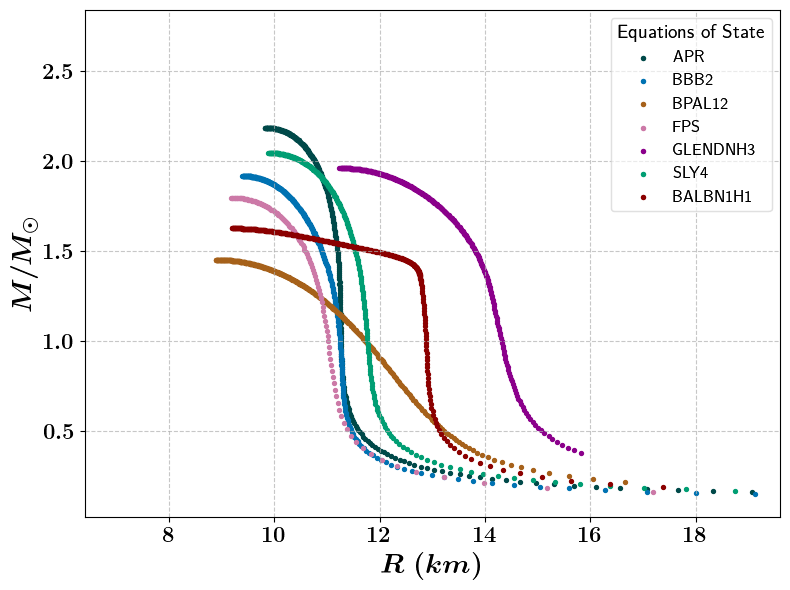

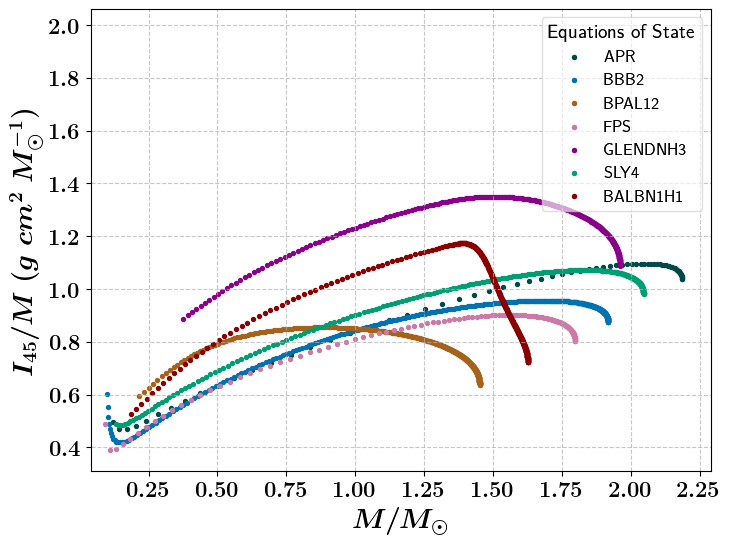

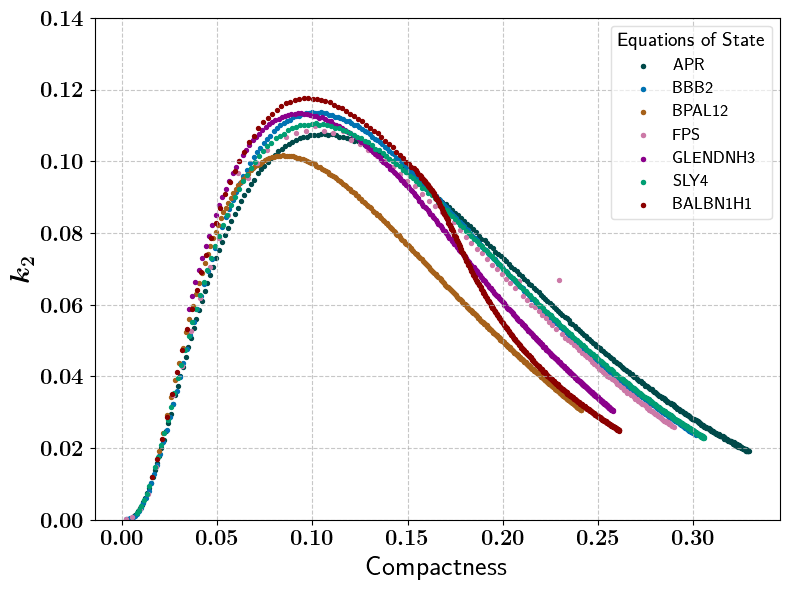

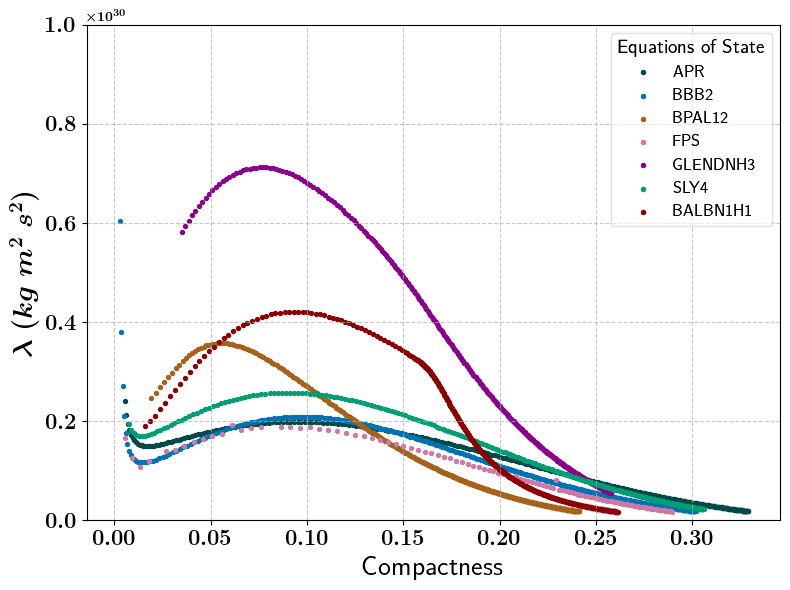

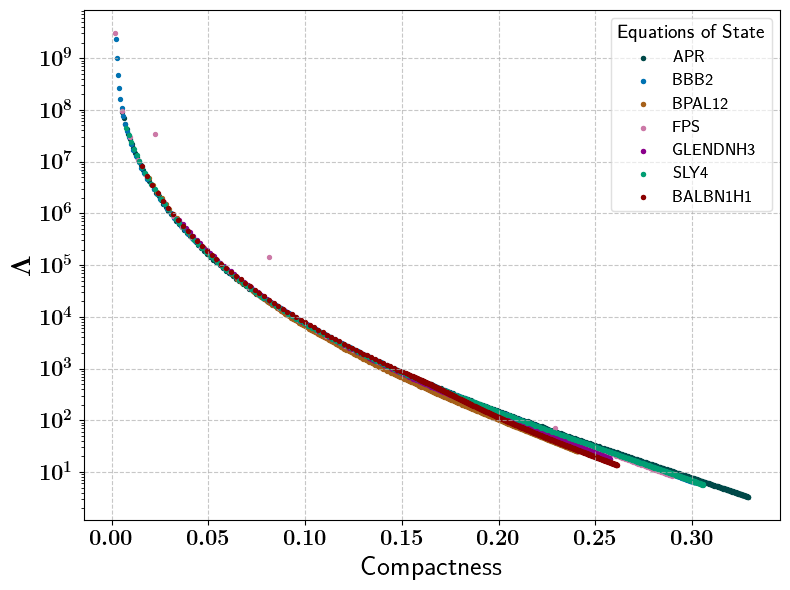

In [18]:
eos_names = ["apr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["#004949", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B",  "#009E73", "#8B0000"]

cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']  # Column names

# Mass vs Radius Plot
plt.figure(figsize=(8, 6))
eos_handles = []
for i, eos_name in enumerate(eos_names):
    #df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)
    df = pd.read_csv(f'../output/{eos_name}/1000_MoIL.dat', names=cols)

    # Find index of maximum mass and truncate data
    max_mass_idx = df['M'].idxmax()
    df = df.iloc[:max_mass_idx + 1]

    line = plt.scatter(df.R, df.M, color=colors[i % len(colors)], s=8, label=eos_name.upper())
    eos_handles.append(line)
    
plt.xlabel(r'$R \ (km)$', fontsize=20)
plt.ylabel(r'$M/M_\odot$', fontsize=20)
plt.xlim(6.4, 19.6)
plt.ylim(0.02, 2.84)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)
first_legend = plt.legend(handles=eos_handles, title="Equations of State", fontsize=12, loc='upper right', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)
plt.tight_layout()
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/M_vs_R.pdf')
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/M_vs_R.png',dpi=600)
plt.show()

# I_45/M plot with \Lambda constraints
plt.figure(figsize=(8, 6))
eos_handles = []
for i, eos_name in enumerate(eos_names):
    #df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)
    df = pd.read_csv(f'../output/{eos_name}/363Hz_MoIL.dat', names=cols)

    # Find index of maximum mass and truncate data
    max_mass_idx = df['M'].idxmax()
    df = df.iloc[:max_mass_idx + 1]

    # Plot the main scatter plot
    line = plt.scatter(df.M, df.I / (1e38 * df.M), color=colors[i % len(colors)], s=8, label=eos_name.upper())
    eos_handles.append(line)
    '''
    # Add GW170817 constraints
    for j in range(len(df.M)):
        if df.L[j] <= 940.45:  # 50% Probability
            plt.scatter(df.M[j], df.I[j] / (1e38 * df.M[j]), color="#88CCEE", marker="o", s=30)
        elif 940.45 < df.L[j] <= 1913.8:  # 90% Probability
            plt.scatter(df.M[j], df.I[j] / (1e38 * df.M[j]), color="#D55E00", marker="s", alpha=0.6, s=30)
    '''
plt.xlabel(r'$M/M_\odot$', fontsize=20)
plt.ylabel(r'$I_{45}/M \ (g \ cm^2 \ M_{\odot}^{-1})$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)
first_legend = plt.legend(handles=eos_handles, title="Equations of State", fontsize=12, loc='upper right', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)
plt.xlim(0.04, 2.29)
plt.ylim(0.31, 2.06)
#plt.savefig('I45_M_vs_M_all_final.png', dpi=300)
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/MOI_slowrot.pdf')
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/MOI_slowrot.png',dpi=600)
plt.show()
'''
# Plot setup
plt.figure(figsize=(8, 6))
for i, eos_name in enumerate(eos_names):
    #df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)
    df = pd.read_csv(f'../output/{eos_name}/1000_MoIL.dat', names=cols)
    max_mass_idx = df['M'].idxmax()
    df = df.iloc[:max_mass_idx + 1]

    plt.scatter(df.M, df.I / (1e38 * df.M), color=colors[i % len(colors)], s=8, label=eos_name)

    for j in range(len(df.M)):
        if df.L[j] <= 940.45:
            plt.scatter(df.M[j], df.I[j] / (1e38 * df.M[j]), color='c', marker='*', s=50, alpha=0.3)
        elif 940.45 < df.L[j] <= 1913.8:
            plt.scatter(df.M[j], df.I[j] / (1e38 * df.M[j]), color='g', marker='*', s=50, alpha=0.3)

# Add your point with error bars
M_star = 1.92
dM = 0.01
I45_M = 1.07
dI = 0.01

plt.errorbar(M_star, I45_M, xerr=dM, yerr=dI, fmt='o', color='red', ecolor='black',
             elinewidth=1.5, capsize=4, label='4U 1728-34')

# Confidence ellipses: 1σ, 3σ, 5σ assuming Gaussian errors and uncorrelated
for n, alpha, color in zip([1, 2, 3], [0.9, 0.7, 0.5], ['blue', 'green', 'yellow']):
    ell = Ellipse((M_star, I45_M), width=2*n*dM, height=2*n*dI,
                  edgecolor=color, facecolor=color, alpha=alpha, linestyle='--', linewidth=1)
    plt.gca().add_patch(ell)

# New NS data
M_ns = 1.3381
dM_ns = 0.0007
I_ns_min = 1.30/M_ns
I_ns_max = 1.976/M_ns
I_ns_mid = (I_ns_min + I_ns_max) / 2
dI_ns = (I_ns_max - I_ns_min) / 2

# Compute I45/M and its propagated error

# Plot this new point
plt.errorbar(M_ns, I_ns_mid, xerr=dM_ns, yerr=dI_ns,
             fmt='o', color='blue', ecolor='navy',
             elinewidth=1.5, capsize=4, label='PSR J0737-3039 A')

# Add confidence ellipses (1σ, 3σ, 5σ)
for n, alpha, color in zip([1, 2, 3], [0.9, 0.7, 0.5], ['red', 'purple', 'cyan']):
    ell = Ellipse((M_ns, I_ns_mid), width=2*n*dM_ns, height=2*n*dI_ns,
                  edgecolor=color, facecolor=color, alpha=alpha, linestyle='--', linewidth=1)
    plt.gca().add_patch(ell)

# Labels and save
plt.xlabel(r'$M/M_\odot$', fontsize=18)
plt.ylabel(r'$I_{45}/M \ (g \ cm^2 \ M_{\odot}^{-1})$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
first_legend = plt.legend(handles=eos_handles, title="Equations of State", fontsize=12, loc='upper right', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)
plt.savefig('I45_M_vs_M_all_4U_1728-34.png', dpi=300)
plt.show()
'''
# k2 vs Compactness Plot
plt.figure(figsize=(8, 6))
eos_handles = []
for i, eos_name in enumerate(eos_names):
    #df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)
    df = pd.read_csv(f'../output/{eos_name}/1000_MoIL.dat', names=cols)

    # Find index of maximum mass and truncate data
    max_mass_idx = df['M'].idxmax()
    df = df.iloc[:max_mass_idx + 1]

    line=plt.scatter(df.C, df.k2, color=colors[i % len(colors)], s=8, label=eos_name.upper())
    eos_handles.append(line)

#plt.xlabel(r'$Compactness$', fontsize=20)
plt.xlabel('Compactness', fontsize=20)
plt.ylabel(r'$k_2$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)
first_legend = plt.legend(handles=eos_handles, title="Equations of State", fontsize=12, loc='upper right', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)
plt.ylim(0,0.14)
plt.tight_layout()
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/k2_vs_C.pdf')
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/k2_vs_C.png',dpi=600)
plt.show()

# l vs Compactness Plot
plt.figure(figsize=(8, 6))
eos_handles = []
for i, eos_name in enumerate(eos_names):
    #df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)
    df = pd.read_csv(f'../output/{eos_name}/1000_MoIL.dat', names=cols)

    # Find index of maximum mass and truncate data
    max_mass_idx = df['M'].idxmax()
    df = df.iloc[:max_mass_idx + 1]

    line=plt.scatter(df.C, df.l, color=colors[i % len(colors)], s=8, label=eos_name.upper())
    eos_handles.append(line)

#plt.xlabel(r'$Compactness$', fontsize=20)
plt.xlabel('Compactness', fontsize=20)
plt.ylabel(r'$\lambda \ (kg \ m^2 \ s^2)$', fontsize=20)
plt.ylim(0, 1e30)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)
first_legend = plt.legend(handles=eos_handles, title="Equations of State", fontsize=12, loc='upper right', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)
plt.tight_layout()
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/l_vs_C.pdf')
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/l_vs_C.png',dpi=600)
plt.show()

# L vs Compactness Plot
plt.figure(figsize=(8, 6))
eos_handles = []
for i, eos_name in enumerate(eos_names):
    #df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)
    df = pd.read_csv(f'../output/{eos_name}/1000_MoIL.dat', names=cols)

    # Find index of maximum mass and truncate data
    max_mass_idx = df['M'].idxmax()
    df = df.iloc[:max_mass_idx + 1]

    line = plt.scatter(df.C, df.L, color=colors[i % len(colors)], s=8, label=eos_name.upper())
    eos_handles.append(line)

#plt.xlabel(r'$Compactness$', fontsize=20)
plt.xlabel('Compactness', fontsize=20)
plt.ylabel(r'$\Lambda$', fontsize=20)
plt.yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)
first_legend = plt.legend(handles=eos_handles, title="Equations of State", fontsize=12, loc='upper right', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)
plt.tight_layout()
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/L_vs_C.pdf')
plt.savefig('/home/sanjana/ashoka/thesis/finalplots/L_vs_C.png', dpi=600)
plt.show()

## Comparison with my TOV Solver

Processing akmalpr:   0%|                               | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_18731/24864388.py:47: RuntimeWarning: invalid value encountered in log
  log_pressure = np.log(pressure)
Processing akmalpr:  99%|█████████████████████▊| 99/100 [00:27<00:00,  3.82it/s]

Processing bbb2:  99%|████████████████████████▊| 99/100 [00:30<00:00,  2.36it/s]

Processing balbn1h1: 100%|████████████████████| 100/100 [00:32<00:00,  3.04it/s]


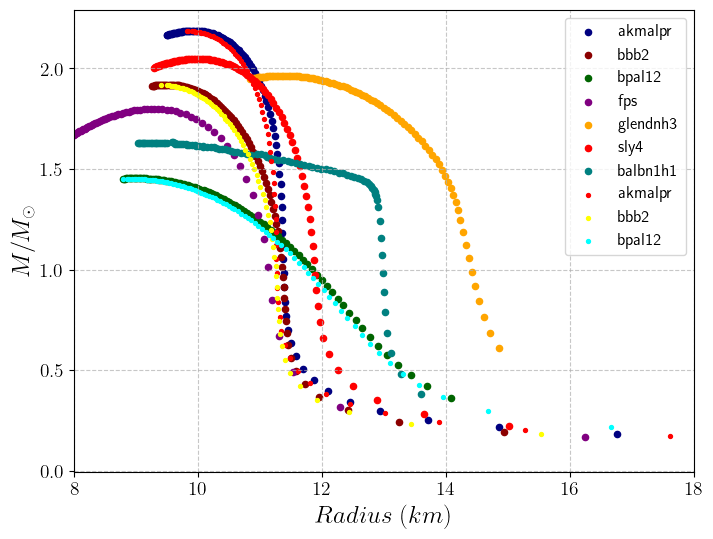

In [42]:
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import re
import csv
from numba import njit

G = 6.6743e-8  # cm^3/g/s^2
c = 29979245800     # cm/s

# Array of EOS names
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
source_dir = '/home/sanjana/ashoka/thesis/EoS/'  # Directory containing EOS files

# Define markers and colors for different EOS
markers = ['+', '+', '+', '+', '+', '+', '+']
colors = ["navy", "darkred", "darkgreen", "purple", "orange", "red", "teal"]

eos_results = {}

# Loop over each EOS
for eos_name in eos_names:
    data = np.genfromtxt(f"{source_dir}eos_{eos_name}.txt", delimiter=None)
    baryon_density = data[:, 1]
    density = data[:, 2]
    pressure = data[:, 3]

    min_density = 3.2e14 #np.min(density) #1e14  # Lower bound on central density
    max_density = np.max(density)
    
    valid_indices = (density > 0) & (pressure > 0)
    density = density[valid_indices]
    pressure = pressure[valid_indices]
    baryon_density = baryon_density[valid_indices]
    
    log_density = np.log(density)
    log_pressure = np.log(pressure)
    #'''
    log_pressure_to_log_density = CubicSpline(log_pressure, log_density, extrapolate=False)
    log_density_to_log_pressure = CubicSpline(log_density, log_pressure, extrapolate=False)
    #'''    
    '''
    log_pressure_to_log_density = interp1d(log_pressure, log_density, kind='cubic', bounds_error=True)
    log_density_to_log_pressure = interp1d(log_density, log_pressure, kind='cubic', bounds_error=True)
    '''
    def pressure_to_density(pressure):
        log_pressure = np.log(pressure)
        # Determine the valid range
        min_log_p, max_log_p = log_pressure_to_log_density.x[0], log_pressure_to_log_density.x[-1]
    
        # Clip values outside the interpolation range and show a warning
        if log_pressure < min_log_p or log_pressure > max_log_p:
            clipped_value = np.exp(np.clip(log_pressure, min_log_p, max_log_p))
            print(f"Warning: Extrapolation detected for pressure {pressure:.10e}, clipping to {clipped_value:.10e}.")
            log_pressure = np.clip(log_pressure, min_log_p, max_log_p)
    
        log_density = log_pressure_to_log_density(log_pressure)
        return np.exp(log_density)
    
    def density_to_pressure(density):
        log_density = np.log(density)
        # Determine the valid range
        min_log_rho, max_log_rho = log_density_to_log_pressure.x[0], log_density_to_log_pressure.x[-1]
    
        # Clip values outside the interpolation range and show a warning
        if log_density < min_log_rho or log_density > max_log_rho:
            clipped_value = np.exp(np.clip(log_density, min_log_rho, max_log_rho))
            print(f"Warning: Extrapolation detected for density {density:.10e}, clipping to {clipped_value:.10e}.")
            log_density = np.clip(log_density, min_log_rho, max_log_rho)
    
        log_pressure = log_density_to_log_pressure(log_density)
        return np.exp(log_pressure)

    # TOV equations
    def TOV(r, state_vars):
        mass, pressure = state_vars
        
        density = pressure_to_density(pressure)
        dm_dr = 4.0 * np.pi * (r**2) * density
        dP_dr = -(((G * mass * density) / (r**2)) * (1 + (pressure / (density * c * c))) *
                  (1 + ((4 * np.pi * pressure * (r**3)) / (mass * c * c)))) / (1 - ((2 * G * mass) / (r * c * c)))
        return [dm_dr, dP_dr]

    # Stopping condition for solve_ivp
    def pressure_stop_condition(r, y):
        return y[1] - 1e-10 * density_to_pressure(min_density)  # Stop when P < threshold

    pressure_stop_condition.terminal = True  # Stop integration
    pressure_stop_condition.direction = -1  # Stop when pressure is decreasing

    # Solve the neutron star structure
    def solve_neutron_star_structure(central_density):
        initial_pressure = density_to_pressure(central_density)
        state_variables_initial = [1e-20, initial_pressure]  # Small initial mass

        sol = solve_ivp(TOV, [1e-25, 2e6], state_variables_initial, method="RK45",
                        rtol=1e-4, atol=1e-4, events=pressure_stop_condition)

        # Determine stopping radius
        if sol.status == 1 and sol.t_events[0].size > 0:  
            stopping_radius = sol.t_events[0][0]  # Stopping point due to pressure threshold
            #print(f"Stopped at r={stopping_radius:.4f} cm due to pressure threshold.")
        else:
            stopping_radius = sol.t[-1]  # If not stopped by event, take last value
            #print("Solve_ivp reached the maximum radius without stopping.")

        final_radius = stopping_radius  # cm
        final_mass = sol.y[0, -1]  # g
        return final_radius, final_mass
    
    central_densities = np.linspace(min_density, max_density, 100)
    results = np.zeros([2, len(central_densities)])

    for i in tqdm(range(len(central_densities)), desc=f"Processing {eos_name}"):
        results[:, i] = solve_neutron_star_structure(central_densities[i])

    radius = results[0,] / 1e5  # Convert to km
    mass = results[1,] / 1.989e33  # Convert to solar masses
    eos_results[eos_name] = (central_densities, radius, mass)

plt.figure(figsize=(8, 6))
# Define colors and markers for distinction
colors = ["navy", "darkred", "darkgreen", "purple", "orange", "red", "teal"]
marker_size = 10  # Reduce marker size here
markers = ["o", "o", "o", "o", "o", "o", "o"]

for eos_name, (central_densities, radius, mass), marker, color in zip(eos_results.keys(), eos_results.values(), markers, colors):
    plt.scatter(radius, mass, label=f"{eos_name}", marker=marker, color=color, s=20)
#plt.savefig("MvsRStat_Comparison_full.pdf")

eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["red", "yellow", "cyan", "lightgreen", "violet", "olive", "orange"]

cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']  # Column names

# Mass vs Radius Plot
for i, eos_name in enumerate(eos_names):
    df = pd.read_csv(f'../output/{eos_name}/MoIL.dat', names=cols)

    # Find index of maximum mass and truncate data
    max_mass_idx = df['M'].idxmax()
    df = df.iloc[:max_mass_idx + 1]

    plt.scatter(df.R, df.M, color=colors[i % len(colors)], s=8, label=eos_name)

plt.xlabel(r'$Radius \ (km)$', fontsize=18)
plt.ylabel(r'$M/M_\odot$', fontsize=18)
plt.xlim(8,18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

## Comaparison with LORENE

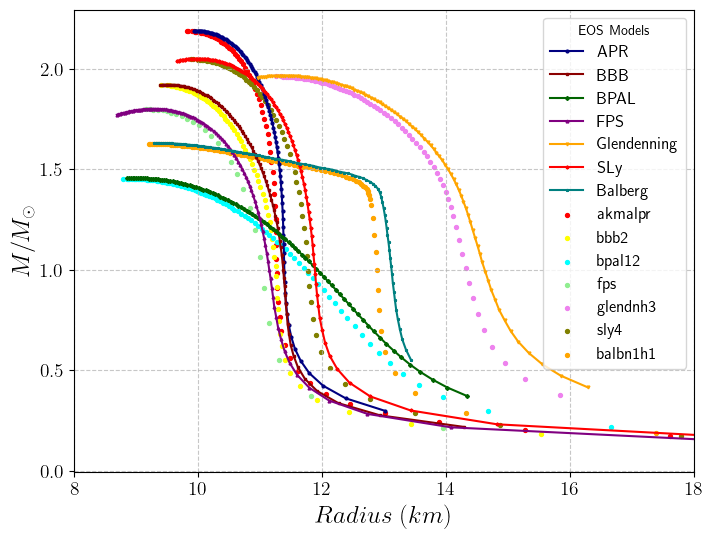

In [51]:
# Base directory for EOS files
lorene_directory = '/home/sanjana/ashoka/thesis/lorene_stuff/'

# EOS file mapping (Stationary Neutron Star)
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_1Hz_nrot_extracted_data.csv",
    "BBB": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_1Hz_nrot_extracted_data.csv",
    "BPAL": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_1Hz_nrot_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_1Hz_nrot_extracted_data.csv",
    "Glendenning": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_1Hz_nrot_extracted_data.csv",
    "SLy": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_1Hz_nrot_extracted_data.csv",
    "Balberg": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_1Hz_nrot_extracted_data.csv"
}

# Colors and markers for different EOS models
colors = ["navy", "darkred", "darkgreen", "purple", "orange", "red", "teal"]
markers = ["o", "s", "D", "^", "v", "P", "*"]
marker_size = 2  

# Column names for the CSV files
cols = ["Mean radius", "Gravitational mass"]

# Plot Mass vs Radius for stationary neutron stars
plt.figure(figsize=(8, 6))

for (eos, file), color, marker in zip(eos_files_stationary.items(), colors, markers):
    if not os.path.exists(file):
        print(f"Warning: File not found for {eos}: {file}")
        continue  # Skip missing files

    # Read only required columns & ensure numeric conversion
    df = pd.read_csv(file, usecols=cols).dropna()

    plt.plot(df["Mean radius"], df["Gravitational mass"], marker=marker, linestyle="-", 
             color=color, label=eos, markersize=marker_size)

# -------------------------------------------------------------------------------------------------
# Mass vs Radius Plot for Rotating Stars (MoIL.dat files)
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["red", "yellow", "cyan", "lightgreen", "violet", "olive", "orange"]


for i, eos_name in enumerate(eos_names):
    file_path = f'../output/{eos_name}/MoIL.dat'
    if not os.path.exists(file_path):
        print(f"Warning: File not found for {eos_name}: {file_path}")
        continue

    df = pd.read_csv(file_path, names=['M', 'R', 'C', 'k2', 'l', 'L', 'I']).dropna()

    # Find the index of max mass and truncate
    max_mass_idx = df['M'].idxmax()
    df = df.iloc[:max_mass_idx + 1]

    plt.scatter(df.R, df.M, color=colors[i % len(colors)], s=8, label=eos_name)

plt.xlabel(r'$Radius \ (km)$', fontsize=18)
plt.ylabel(r'$M/M_\odot$', fontsize=18)
plt.xlim(8, 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(title="EOS Models", fontsize=12)
plt.show()

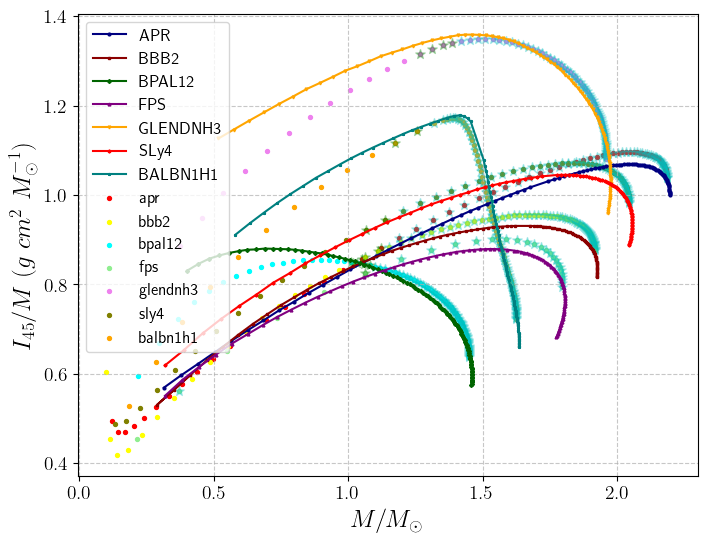

In [25]:
# Base directory for EOS files
lorene_directory = '/home/sanjana/ashoka/thesis/lorene_stuff/'

# EOS file mapping (Stationary Neutron Star)

eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_363Hz_nrot_extracted_data.csv",
    "BBB2": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_363Hz_nrot_extracted_data.csv",
    "BPAL12": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_363Hz_nrot_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_363Hz_nrot_extracted_data.csv",
    "GLENDNH3": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_363Hz_nrot_extracted_data.csv",
    "SLy4": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_363Hz_nrot_extracted_data.csv",
    "BALBN1H1": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_363Hz_nrot_extracted_data.csv"
}
'''
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_300Hz_extracted_data.csv",
    "BBB": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_300Hz_extracted_data.csv",
    "BPAL": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_300Hz_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "Glendenning": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_300Hz_extracted_data.csv",
    "SLy": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "Balberg": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_300Hz_extracted_data.csv"
}
'''

# Colors and markers for different EOS models
colors = ["navy", "darkred", "darkgreen", "purple", "orange", "red", "teal"]
markers = ["o", "s", "D", "^", "v", "P", "*"]
marker_size = 2  

# Column names for the CSV files
cols = ["Gravitational mass", "Moment of inertia"]

# Plot Mass vs Radius for stationary neutron stars
plt.figure(figsize=(8, 6))

for (eos, file), color, marker in zip(eos_files_stationary.items(), colors, markers):
    if not os.path.exists(file):
        print(f"Warning: File not found for {eos}: {file}")
        continue  # Skip missing files

    # Read only required columns & ensure numeric conversion
    df = pd.read_csv(file, usecols=cols).dropna()

    plt.plot(df["Gravitational mass"], df["Moment of inertia"]/df["Gravitational mass"], marker=marker, linestyle="-", 
             color=color, label=eos, markersize=marker_size)

# -------------------------------------------------------------------------------------------------
eos_names = ["apr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["red", "yellow", "cyan", "lightgreen", "violet", "olive", "orange"]
cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']  # Column names
for i, eos_name in enumerate(eos_names):
    df = pd.read_csv(f'../output/{eos_name}/363Hz_MoIL.dat', names=cols)

    # Find index of maximum mass and truncate data
    max_mass_idx = df['M'].idxmax()
    df = df.iloc[:max_mass_idx + 1]

    # Plot the main scatter plot
    plt.scatter(df.M, df.I / (1e38 * df.M), color=colors[i % len(colors)], s=8, label=eos_name)

    # Add GW170817 constraints
    for j in range(len(df.M)):
        if df.L[j] <= 940.45:  # 50% Probability
            plt.scatter(df.M[j], df.I[j] / (1e38 * df.M[j]), color='c', marker='*', s=50, alpha=0.3)
        elif 940.45 < df.L[j] <= 1913.8:  # 90% Probability
            plt.scatter(df.M[j], df.I[j] / (1e38 * df.M[j]), color='g', marker='*', s=50, alpha=0.3)

plt.xlabel(r'$M/M_\odot$', fontsize=18)
plt.ylabel(r'$I_{45}/M \ (g \ cm^2 \ M_{\odot}^{-1})$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

## Mass Constraints?

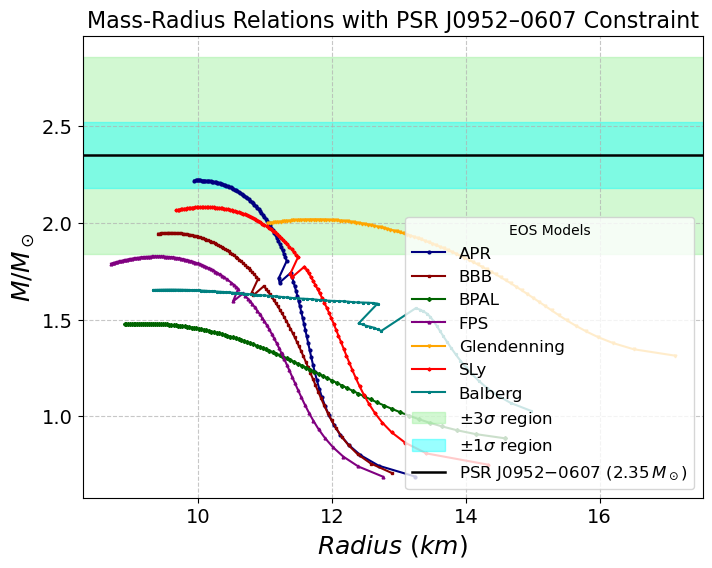

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Directory and files
lorene_directory = '/home/sanjana/ashoka/thesis/lorene_stuff/'

eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_4499Hz_nrot_extracted_data.csv",
    "BBB": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_4499Hz_nrot_extracted_data.csv",
    "BPAL": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_4499Hz_nrot_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_4499Hz_nrot_extracted_data.csv",
    "Glendenning": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_4499Hz_nrot_extracted_data.csv",
    "SLy": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_4499Hz_nrot_extracted_data.csv",
    "Balberg": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_4499Hz_nrot_extracted_data.csv"
}

colors = ["navy", "darkred", "darkgreen", "purple", "orange", "red", "teal"]
markers = ["o", "s", "D", "^", "v", "P", "*"]
marker_size = 2  
cols = ["Mean radius", "Gravitational mass"]

# PSR J0952–0607 mass and uncertainty
psr_mass = 2.35
sigma = 0.17

plt.figure(figsize=(8, 6))

for (eos_name, file), color, marker in zip(eos_files_stationary.items(), colors, markers):
    if not os.path.exists(file):
        print(f"Warning: File not found for {eos_name}: {file}")
        continue

    df = pd.read_csv(file, usecols=cols).dropna()

    plt.plot(df["Mean radius"], df["Gravitational mass"], marker=marker, linestyle="-", 
             color=color, label=eos_name, markersize=marker_size)

# Add PSR J0952–0607 lines
# Add shaded regions for PSR J0952–0607 ±1σ and ±3σ
plt.axhspan(psr_mass - 3*sigma, psr_mass + 3*sigma, color='lightgreen', alpha=0.4, label=r'$\pm3\sigma$ region')
plt.axhspan(psr_mass - sigma, psr_mass + sigma, color='cyan', alpha=0.4, label=r'$\pm1\sigma$ region')

# Add a central line at the measured mass
plt.axhline(psr_mass, color="black", linestyle="-", linewidth=1.8, label=r'PSR J0952$-$0607 ($2.35\,M_\odot$)')

# Labels and styling
plt.xlabel(r'$Radius \ (km)$', fontsize=18)
plt.ylabel(r'$M/M_\odot$', fontsize=18)
#plt.xlim(8, 18)
#plt.ylim(1.0, 2.9)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(title="EOS Models", fontsize=12, loc='lower right')
plt.title("Mass-Radius Relations with PSR J0952–0607 Constraint", fontsize=16)

plt.show()

## Mass-Radius Constraints with multiple NS

/tmp/ipykernel_1658145/874005120.py:102: RuntimeWarning: divide by zero encountered in divide
  freq_ns = np.where(spin_s_ns != 0, 1 / spin_s_ns, 0)


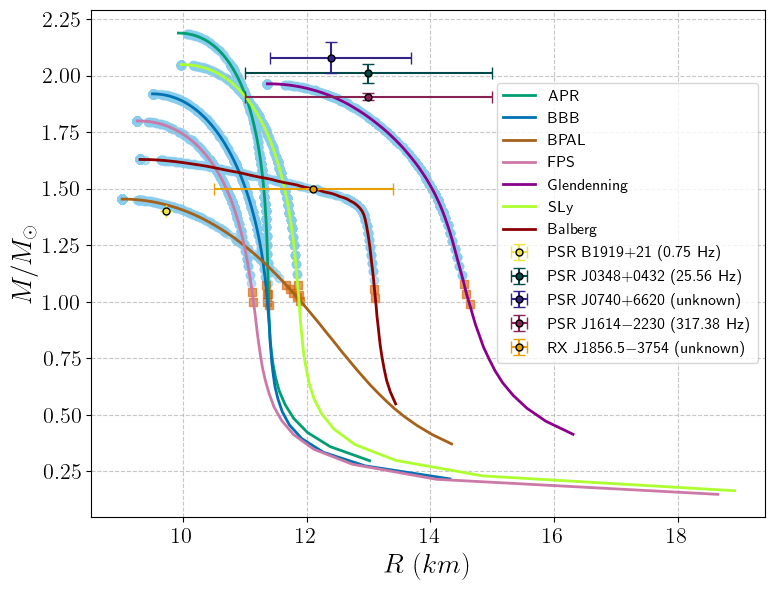

In [89]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Define EOS names and colors
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
#colors = ["navy", "darkred", "darkgreen", "purple", "orange", "red", "teal"]
colors = ["#009E73", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B",  "#ADFF2F", "#8B0000"]

# Columns in MoIL.dat
cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']
mass50, mass90 = [], []

# Extract masses from MoIL.dat using tidal deformability limits
for eos_name in eos_names:
    df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)
    df = df.iloc[:df['M'].idxmax() + 1]

    for _, row in df.iterrows():
        if row['L'] <= 940.45:
            mass50.append(row['M'])
        elif 940.45 < row['L'] <= 1913.8:
            mass90.append(row['M'])

mass50 = np.array(mass50)
mass90 = np.array(mass90)

# Define Lorene data directory and EOS mapping
lorene_directory = "/home/sanjana/ashoka/thesis/lorene_stuff/"
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_300Hz_extracted_data.csv",
    "BBB": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_300Hz_extracted_data.csv",
    "BPAL": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_300Hz_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "Glendenning": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_300Hz_extracted_data.csv",
    "SLy": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "Balberg": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_300Hz_extracted_data.csv"
}

# Columns to extract: Mass and Radius
cols = ["Gravitational mass", "Mean radius"]
mass50_nearest, mass90_nearest = {}, {}
radius50_nearest, radius90_nearest = {}, {}

plt.figure(figsize=(8, 6))

for eos, file in eos_files_stationary.items():
    if not os.path.exists(file):
        print(f"Warning: File not found for {eos}: {file}")
        continue

    df = pd.read_csv(file, usecols=cols).dropna()
    mass_values_raw = df["Gravitational mass"].values
    radius_values_raw = df["Mean radius"].values

    # Enforce monotonic increase in mass
    valid_indices = [0]
    for i in range(1, len(mass_values_raw)):
        if mass_values_raw[i] > mass_values_raw[valid_indices[-1]]:
            valid_indices.append(i)

    mass_values = mass_values_raw[valid_indices]
    radius_values = radius_values_raw[valid_indices]

    color = colors[list(eos_files_stationary.keys()).index(eos)]
    plt.plot(radius_values, mass_values, linestyle="-", color=color, linewidth=2, label=eos)

    # Match constrained masses
    nearest_mass50 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass50]
    nearest_mass90 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass90]
    nearest_mass90 = np.array(list(set(nearest_mass90) - set(nearest_mass50)))  # Avoid overlaps

    corresponding_radius50 = [radius_values[np.abs(mass_values - m).argmin()] for m in nearest_mass50]
    corresponding_radius90 = [radius_values[np.abs(mass_values - m).argmin()] for m in nearest_mass90]

    mass50_nearest[eos] = np.array(nearest_mass50)
    mass90_nearest[eos] = np.array(nearest_mass90)
    radius50_nearest[eos] = np.array(corresponding_radius50)
    radius90_nearest[eos] = np.array(corresponding_radius90)

# Scatter plot of GW170817 constraints
for eos in eos_files_stationary.keys():
    if eos in mass50_nearest:
        plt.scatter(radius50_nearest[eos],mass50_nearest[eos], color="#88CCEE", marker="o", alpha=0.6)
    if eos in mass90_nearest:
        plt.scatter(radius90_nearest[eos],mass90_nearest[eos], color="#D55E00", marker="s", alpha=0.6)

masses_ns = np.array([1.4, 2.01, 2.08, 1.908, 1.5]) #1.35, 1.4,
radii_ns = np.array([9.7398, 13.0, 12.39, 13.0, 12.1]) #20.85, 19.0
spin_s_ns = np.array([1.3373, 0.0391226569017806, 0, 0.0031508076534271, 0]) #0, 0.0058
labels_ns = np.array([
    "PSR B1919+21",
    "PSR J0348+0432", #https://en.wikipedia.org/wiki/PSR_J0348%2B0432
    "PSR J0740+6620", #https://en.wikipedia.org/wiki/PSR_J0740%2B6620
    "PSR J1614−2230", #Arzoumanian2018
    "RX J1856.5−3754" #https://en.wikipedia.org/wiki/RX_J1856.5%E2%88%923754
]) #"PSR B1620−26","PSR J1719−1438",

# Compute frequency in Hz and angular velocity (omega)
freq_ns = np.where(spin_s_ns != 0, 1 / spin_s_ns, 0)
omega_ns = 2 * np.pi * freq_ns

# Colormap for different stars
num_stars = len(labels_ns)
colors_ns = np.array(["#F0E442", "#004949", "#332288", "#882255", "#E69F00"])

# Convert symmetric errors to 2D arrays for matplotlib
mass_errors_ns = np.array([
    [0.0, 0.04, 0.07, 0.016, 0.0],  # lower
    [0.0, 0.04, 0.07, 0.016, 0.0]   # upper
])

radius_errors_ns = np.array([
    [0.0, 2.0, 0.98, 2.0, 1.6],    # lower
    [0.0, 2.0, 1.30, 2.0, 1.3]     # upper
])

for i, (radius, mass, label, freq) in enumerate(zip(radii_ns, masses_ns, labels_ns, freq_ns)):
    label_with_freq = f"{label} ({freq:.2f} Hz)" if freq > 0 else f"{label} (unknown)"
    color = colors_ns[i]

    plt.errorbar(
        radius, mass,
        xerr=[[radius_errors_ns[0][i]], [radius_errors_ns[1][i]]],
        yerr=[[mass_errors_ns[0][i]], [mass_errors_ns[1][i]]],
        fmt='o',
        color=color,
        markersize=5,
        markeredgecolor='black',
        markeredgewidth=1,
        capsize=4,
        label=label_with_freq,
        zorder=10
    )

# Final formatting
plt.ylabel(r'$M/M_\odot$', fontsize=20)
plt.xlabel(r'$R \ (km)$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(fontsize=11.5, loc='center left', bbox_to_anchor=(0.59, 0.58))
plt.tight_layout()
plt.savefig("Mass_Radius_with_constraints_1.png", dpi=300)
plt.show()

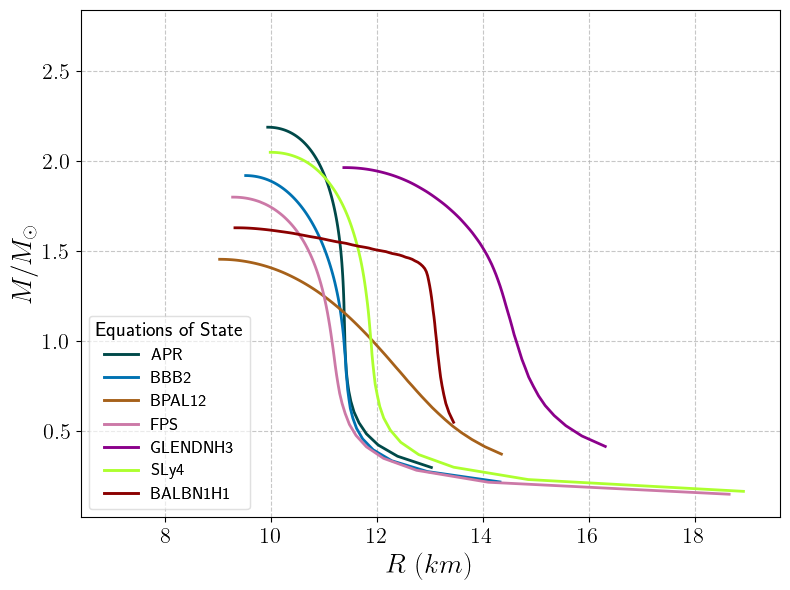

In [20]:
# Define EOS names and colors
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["#004949", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B",  "#ADFF2F", "#8B0000"]

# Columns in MoIL.dat
cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']
mass50, mass90 = [], []

# Extract masses from MoIL.dat using tidal deformability limits
for eos_name in eos_names:
    df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)
    df = df.iloc[:df['M'].idxmax() + 1]

    for _, row in df.iterrows():
        if row['L'] <= 940.45:
            mass50.append(row['M'])
        elif 940.45 < row['L'] <= 1913.8:
            mass90.append(row['M'])

mass50 = np.array(mass50)
mass90 = np.array(mass90)

# Define Lorene data directory and EOS mapping
lorene_directory = "/home/sanjana/ashoka/thesis/lorene_stuff/"
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_300Hz_extracted_data.csv",
    "BBB2": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_300Hz_extracted_data.csv",
    "BPAL12": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_300Hz_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "GLENDNH3": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_300Hz_extracted_data.csv",
    "SLy4": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "BALBN1H1": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_300Hz_extracted_data.csv"
}

cols = ["Gravitational mass", "Mean radius"]
mass50_nearest, mass90_nearest = {}, {}
radius50_nearest, radius90_nearest = {}, {}

plt.figure(figsize=(8, 6))
eos_handles = []

for eos, file in eos_files_stationary.items():
    if not os.path.exists(file):
        print(f"Warning: File not found for {eos}: {file}")
        continue

    df = pd.read_csv(file, usecols=cols).dropna()
    mass_values_raw = df["Gravitational mass"].values
    radius_values_raw = df["Mean radius"].values

    valid_indices = [0]
    for i in range(1, len(mass_values_raw)):
        if mass_values_raw[i] > mass_values_raw[valid_indices[-1]]:
            valid_indices.append(i)

    mass_values = mass_values_raw[valid_indices]
    radius_values = radius_values_raw[valid_indices]

    color = colors[list(eos_files_stationary.keys()).index(eos)]
    line, = plt.plot(radius_values, mass_values, linestyle="-", color=color, linewidth=2, label=eos)
    eos_handles.append(line)

    nearest_mass50 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass50]
    nearest_mass90 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass90]
    nearest_mass90 = np.array(list(set(nearest_mass90) - set(nearest_mass50)))

    corresponding_radius50 = [radius_values[np.abs(mass_values - m).argmin()] for m in nearest_mass50]
    corresponding_radius90 = [radius_values[np.abs(mass_values - m).argmin()] for m in nearest_mass90]

    mass50_nearest[eos] = np.array(nearest_mass50)
    mass90_nearest[eos] = np.array(nearest_mass90)
    radius50_nearest[eos] = np.array(corresponding_radius50)
    radius90_nearest[eos] = np.array(corresponding_radius90)

# Final formatting
plt.ylabel(r'$M/M_\odot$', fontsize=20)
plt.xlabel(r'$R \ (km)$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)

# TWO LEGENDS
first_legend = plt.legend(handles=eos_handles, title="Equations of State", fontsize=12, loc='lower left', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)

plt.xlim(6.4, 19.6)
plt.ylim(0.02, 2.84)

plt.tight_layout()
#plt.savefig("/home/sanjana/ashoka/thesis/finalplots/Mass_Radius_with_no_constraints.png", dpi=300)
plt.savefig("/home/sanjana/ashoka/thesis/finalplots/Mass_Radius_with_no_constraints.pdf")
plt.show()

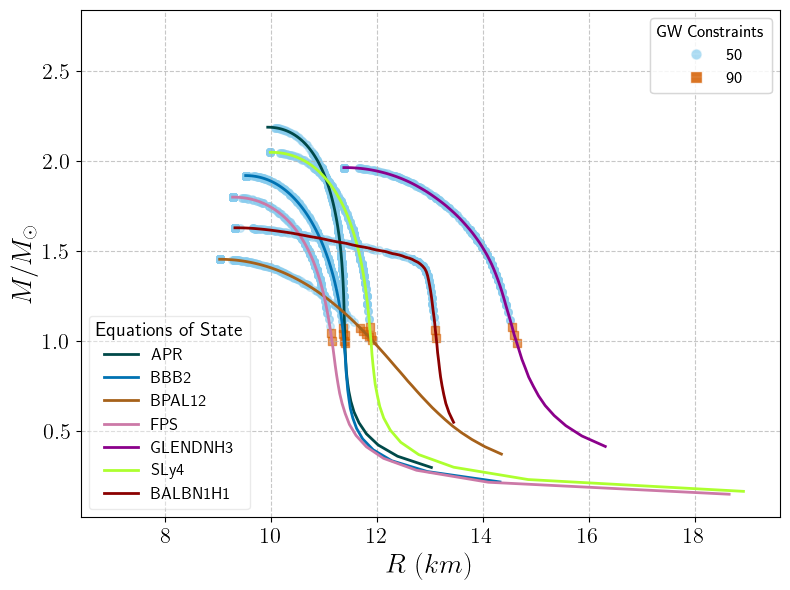

In [19]:
# Define EOS names and colors
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["#004949", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B",  "#ADFF2F", "#8B0000"]

# Columns in MoIL.dat
cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']
mass50, mass90 = [], []

# Extract masses from MoIL.dat using tidal deformability limits
for eos_name in eos_names:
    df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)
    df = df.iloc[:df['M'].idxmax() + 1]

    for _, row in df.iterrows():
        if row['L'] <= 940.45:
            mass50.append(row['M'])
        elif 940.45 < row['L'] <= 1913.8:
            mass90.append(row['M'])

mass50 = np.array(mass50)
mass90 = np.array(mass90)

# Define Lorene data directory and EOS mapping
lorene_directory = "/home/sanjana/ashoka/thesis/lorene_stuff/"
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_300Hz_extracted_data.csv",
    "BBB2": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_300Hz_extracted_data.csv",
    "BPAL12": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_300Hz_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "GLENDNH3": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_300Hz_extracted_data.csv",
    "SLy4": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "BALBN1H1": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_300Hz_extracted_data.csv"
}

cols = ["Gravitational mass", "Mean radius"]
mass50_nearest, mass90_nearest = {}, {}
radius50_nearest, radius90_nearest = {}, {}

plt.figure(figsize=(8, 6))
eos_handles = []

for eos, file in eos_files_stationary.items():
    if not os.path.exists(file):
        print(f"Warning: File not found for {eos}: {file}")
        continue

    df = pd.read_csv(file, usecols=cols).dropna()
    mass_values_raw = df["Gravitational mass"].values
    radius_values_raw = df["Mean radius"].values

    valid_indices = [0]
    for i in range(1, len(mass_values_raw)):
        if mass_values_raw[i] > mass_values_raw[valid_indices[-1]]:
            valid_indices.append(i)

    mass_values = mass_values_raw[valid_indices]
    radius_values = radius_values_raw[valid_indices]

    color = colors[list(eos_files_stationary.keys()).index(eos)]
    line, = plt.plot(radius_values, mass_values, linestyle="-", color=color, linewidth=2, label=eos)
    eos_handles.append(line)

    nearest_mass50 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass50]
    nearest_mass90 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass90]
    nearest_mass90 = np.array(list(set(nearest_mass90) - set(nearest_mass50)))

    corresponding_radius50 = [radius_values[np.abs(mass_values - m).argmin()] for m in nearest_mass50]
    corresponding_radius90 = [radius_values[np.abs(mass_values - m).argmin()] for m in nearest_mass90]

    mass50_nearest[eos] = np.array(nearest_mass50)
    mass90_nearest[eos] = np.array(nearest_mass90)
    radius50_nearest[eos] = np.array(corresponding_radius50)
    radius90_nearest[eos] = np.array(corresponding_radius90)

# GW170817 Constraints
for eos in eos_files_stationary.keys():
    if eos in mass50_nearest:
        plt.scatter(radius50_nearest[eos], mass50_nearest[eos], color="#88CCEE", marker="o", alpha=0.4, s=30)
    if eos in mass90_nearest:
        plt.scatter(radius90_nearest[eos], mass90_nearest[eos], color="#D55E00", marker="s", alpha=0.6, s=30)

# Final formatting
plt.ylabel(r'$M/M_\odot$', fontsize=20)
plt.xlabel(r'$R \ (km)$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)

# TWO LEGENDS
first_legend = plt.legend(handles=eos_handles, title="Equations of State", fontsize=12, loc='lower left', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)

# Add second legend for GW170817 Constraints
gw_handles = [
    Line2D([0], [0], marker='o', color='w', label='50% confidence interval',
           markerfacecolor='#88CCEE', markersize=8, alpha=0.6),
    Line2D([0], [0], marker='s', color='w', label='90% confidence interval',
           markerfacecolor='#D55E00', markersize=8, alpha=0.8)
]
# Add second legend for GW170817 Constraints
second_legend = plt.legend(handles=gw_handles, title="GW170817 Constraints",
                           loc='upper right', fontsize=12, title_fontsize=12,framealpha=0.6)
plt.gca().add_artist(second_legend)

plt.xlim(6.4, 19.6)
plt.ylim(0.02, 2.84)

plt.tight_layout()
#plt.savefig("/home/sanjana/ashoka/thesis/finalplots/Mass_Radius_with_gw_constraints.png", dpi=300)
plt.savefig("/home/sanjana/ashoka/thesis/finalplots/Mass_Radius_with_gw_constraints.pdf")
plt.show()

/tmp/ipykernel_2024201/3078815051.py:93: RuntimeWarning: divide by zero encountered in divide
  freq_ns = np.where(spin_s_ns != 0, 1 / spin_s_ns, 0)


X range: 6.4 to 19.6
Y range: 0.006304809044999998 to 3.1425569138549996


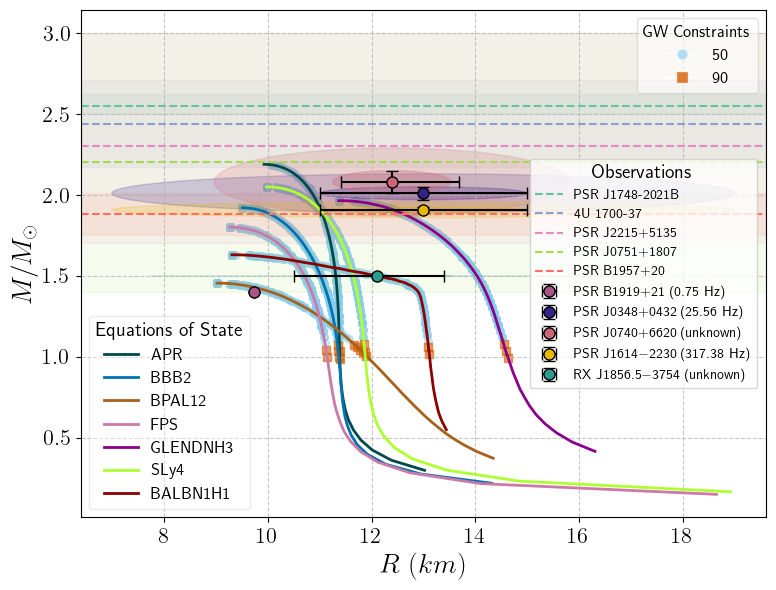

In [2]:
# Define EOS names and colors
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["#004949", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B",  "#ADFF2F", "#8B0000"]

# Columns in MoIL.dat
cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']
mass50, mass90 = [], []

# Extract masses from MoIL.dat using tidal deformability limits
for eos_name in eos_names:
    df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)
    df = df.iloc[:df['M'].idxmax() + 1]

    for _, row in df.iterrows():
        if row['L'] <= 940.45:
            mass50.append(row['M'])
        elif 940.45 < row['L'] <= 1913.8:
            mass90.append(row['M'])

mass50 = np.array(mass50)
mass90 = np.array(mass90)

# Define Lorene data directory and EOS mapping
lorene_directory = "/home/sanjana/ashoka/thesis/lorene_stuff/"
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_300Hz_extracted_data.csv",
    "BBB2": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_300Hz_extracted_data.csv",
    "BPAL12": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_300Hz_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "GLENDNH3": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_300Hz_extracted_data.csv",
    "SLy4": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "BALBN1H1": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_300Hz_extracted_data.csv"
}

cols = ["Gravitational mass", "Mean radius"]
mass50_nearest, mass90_nearest = {}, {}
radius50_nearest, radius90_nearest = {}, {}

plt.figure(figsize=(8, 6))
eos_handles = []

for eos, file in eos_files_stationary.items():
    if not os.path.exists(file):
        print(f"Warning: File not found for {eos}: {file}")
        continue

    df = pd.read_csv(file, usecols=cols).dropna()
    mass_values_raw = df["Gravitational mass"].values
    radius_values_raw = df["Mean radius"].values

    valid_indices = [0]
    for i in range(1, len(mass_values_raw)):
        if mass_values_raw[i] > mass_values_raw[valid_indices[-1]]:
            valid_indices.append(i)

    mass_values = mass_values_raw[valid_indices]
    radius_values = radius_values_raw[valid_indices]

    color = colors[list(eos_files_stationary.keys()).index(eos)]
    line, = plt.plot(radius_values, mass_values, linestyle="-", color=color, linewidth=2, label=eos)
    eos_handles.append(line)

    nearest_mass50 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass50]
    nearest_mass90 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass90]
    nearest_mass90 = np.array(list(set(nearest_mass90) - set(nearest_mass50)))

    corresponding_radius50 = [radius_values[np.abs(mass_values - m).argmin()] for m in nearest_mass50]
    corresponding_radius90 = [radius_values[np.abs(mass_values - m).argmin()] for m in nearest_mass90]

    mass50_nearest[eos] = np.array(nearest_mass50)
    mass90_nearest[eos] = np.array(nearest_mass90)
    radius50_nearest[eos] = np.array(corresponding_radius50)
    radius90_nearest[eos] = np.array(corresponding_radius90)

# GW170817 Constraints
for eos in eos_files_stationary.keys():
    if eos in mass50_nearest:
        plt.scatter(radius50_nearest[eos], mass50_nearest[eos], color="#88CCEE", marker="o", alpha=0.4, s=30)
    if eos in mass90_nearest:
        plt.scatter(radius90_nearest[eos], mass90_nearest[eos], color="#D55E00", marker="s", alpha=0.6, s=30)

masses_ns = np.array([1.4, 2.01, 2.08, 1.908, 1.5])
radii_ns = np.array([9.7398, 13.0, 12.39, 13.0, 12.1])
spin_s_ns = np.array([1.3373, 0.0391226569017806, 0, 0.0031508076534271, 0])
labels_ns = np.array([
    "PSR B1919+21",
    "PSR J0348+0432",
    "PSR J0740+6620",
    "PSR J1614−2230",
    "RX J1856.5−3754"
])

freq_ns = np.where(spin_s_ns != 0, 1 / spin_s_ns, 0)
omega_ns = 2 * np.pi * freq_ns

num_stars = len(labels_ns)
colors_ns = np.array(["#AA5588","#332288","#CC6677","#E6B800", "#2A9D8F"])

mass_errors_ns = np.array([
    [0.0, 0.04, 0.07, 0.016, 0.0],
    [0.0, 0.04, 0.07, 0.016, 0.0]
])

radius_errors_ns = np.array([
    [0.0, 2.0, 0.98, 2.0, 1.6],
    [0.0, 2.0, 1.30, 2.0, 1.3]
])

obs_handles = []
obs_labels = []

# Neutron Star Names
names = [
    "PSR J1748-2021B", "4U 1700-37", "PSR J2017-1614", 
    "PSR J1311–3430", "PSR J1600−3053", "PSR J2215+5135", "XMMU J013236.7+303228", 
    "PSR J0751+1807", "PSR J0740+6620", "PSR J0348+0432", "PSR J1518+0204B (M5B)", 
    "PSR B1516+02B", "Vela X-1", "PSR J2222–0137", "PSR B1957+20", 
    "SWIFT J1756.9-2508"
]

# Masses and uncertainties (mass, lower uncertainty, upper uncertainty)
masses = [
    2.548, 2.44, 2.4, 2.35, 2.15, 2.3, 2.27, 2.2, 2.1, 2.08, 2.01, 1.981, 1.94, 
    1.908, 1.88, 1.831, 1.81, 1.8
]
lower_uncertainty = [
    0.047, 0.27, 0.6, 0.17, 0.55, 0.6, 0.15, 0.8, 0.2, 0.07, 0.04, 0.0, 0.17, 
    0.016, 0.13, 0.0, 0.17, 0.4
]
upper_uncertainty = [
    0.078, 0.27, 0.6, 0.17, 0.55, 0.7, 0.17, 0.8, 0.2, 0.07, 0.04, 0.0, 0.19, 
    0.016, 0.13, 0.0, 0.17, 0.4
]

# List of neutron stars to be removed
remove_ns = [
    "SWIFT J1756.9-2508", "PSR J2222–0137", "Vela X-1", "PSR B1516+02B",
    "PSR J0348+0432", "PSR J0740+6620", "PSR J1311–3430", "PSR J2017-1614", "XMMU J013236.7+303228", "PSR J1600−3053", "PSR J1518+0204B (M5B)", "PSR J1614−2230"
]

# Using list comprehension to filter out the unwanted neutron stars
filtered_names = [name for name in names if name not in remove_ns]
filtered_masses = [mass for name, mass in zip(names, masses) if name not in remove_ns]
filtered_lower_uncertainty = [low for name, low in zip(names, lower_uncertainty) if name not in remove_ns]
filtered_upper_uncertainty = [high for name, high in zip(names, upper_uncertainty) if name not in remove_ns]

# Color palette that is color-blind friendly
colors_line = np.array(["#66C2A5", "#8DA0CB", "#E78AC3", "#A6D854", "#FF6F61"])

# Loop over each mass and draw shaded ±1σ and ±3σ regions along with the central line
for i, (name, mass, low, high) in enumerate(zip(filtered_names, filtered_masses, filtered_lower_uncertainty, filtered_upper_uncertainty)):
    color = colors_line[i]

    # ±3σ region (shaded)
    #plt.axhspan(mass - 3*low, mass + 3*high, color=color, alpha=0.2)

    # ±1σ region (shaded)
    plt.axhspan(mass - low, mass + high, color=color, alpha=0.1)

    # Central line at the mass value
    line = plt.axhline(mass, color=color, linestyle='--', linewidth=1.5, label=f'{name}')

    # Add the line to the legend
    obs_handles.append(line)
    obs_labels.append(name)

for i, (radius, mass, label, freq) in enumerate(zip(radii_ns, masses_ns, labels_ns, freq_ns)):
    label_with_freq = f"{label} ({freq:.2f} Hz)" if freq > 0 else f"{label} (unknown)"
    color = colors_ns[i]

    err = plt.errorbar(
        radius, mass,
        xerr=[[radius_errors_ns[0][i]], [radius_errors_ns[1][i]]],
        yerr=[[mass_errors_ns[0][i]], [mass_errors_ns[1][i]]],
        fmt='o',
        color=color,             # Color of the point
        ecolor='black',          # Color of the error bars
        markersize=8,
        markeredgecolor='black',
        markeredgewidth=1,
        capsize=4,
        label=label_with_freq,
        zorder=10
    )
    obs_handles.append(err)
    obs_labels.append(label_with_freq)

    # Draw 1σ and 3σ ellipses
    for nsigma, alpha in zip([1, 3], [0.3, 0.2]):
        width = 2 * nsigma * np.mean([radius_errors_ns[0][i], radius_errors_ns[1][i]])
        height = 2 * nsigma * np.mean([mass_errors_ns[0][i], mass_errors_ns[1][i]])
        ellipse = Ellipse(
            (radius, mass),
            width=width,
            height=height,
            edgecolor=color,
            facecolor=color,
            lw=1,
            alpha=alpha,
            zorder=1
        )
        plt.gca().add_patch(ellipse)

# Final formatting
plt.ylabel(r'$M/M_\odot$', fontsize=20)
plt.xlabel(r'$R \ (km)$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)

# TWO LEGENDS
first_legend = plt.legend(handles=eos_handles, title="Equations of State", fontsize=12, loc='lower left', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)

# Add second legend for GW170817 Constraints
gw_handles = [
    Line2D([0], [0], marker='o', color='w', label='50% confidence interval',
           markerfacecolor='#88CCEE', markersize=8, alpha=0.6),
    Line2D([0], [0], marker='s', color='w', label='90% confidence interval',
           markerfacecolor='#D55E00', markersize=8, alpha=0.8)
]
# Add second legend for GW170817 Constraints
second_legend = plt.legend(handles=gw_handles, title="GW170817 Constraints",
                           loc='upper right', fontsize=12, title_fontsize=12,framealpha=0.6)
plt.gca().add_artist(second_legend)

third_legend = plt.legend(handles=obs_handles, labels=obs_labels, title="Observations", fontsize=10 , loc='center left', bbox_to_anchor=(0.6448, 0.48), title_fontsize=14)

#plt.xlim(6.4, 19.6)
#plt.ylim(0.02, 3)

# Get current axes
ax = plt.gca()

# Get limits
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

print("X range:", x_min, "to", x_max)
print("Y range:", y_min, "to", y_max)

plt.tight_layout()
#plt.savefig("/home/sanjana/ashoka/thesis/finalplots/Mass_Radius_with_obs_constraints.png", dpi=300)
plt.savefig("/home/sanjana/ashoka/thesis/finalplots/Mass_Radius_with_obs_constraints.pdf")
plt.show()


/tmp/ipykernel_1658145/1640574606.py:99: RuntimeWarning: divide by zero encountered in divide
  freq_ns = np.where(spin_s_ns != 0, 1 / spin_s_ns, 0)


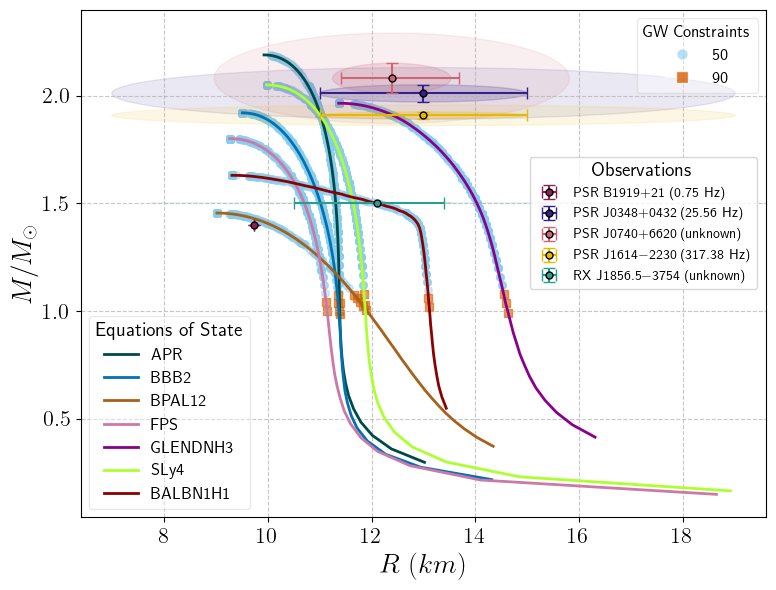

In [129]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Define EOS names and colors
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["#004949", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B",  "#ADFF2F", "#8B0000"]

# Columns in MoIL.dat
cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']
mass50, mass90 = [], []

# Extract masses from MoIL.dat using tidal deformability limits
for eos_name in eos_names:
    df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)
    df = df.iloc[:df['M'].idxmax() + 1]

    for _, row in df.iterrows():
        if row['L'] <= 940.45:
            mass50.append(row['M'])
        elif 940.45 < row['L'] <= 1913.8:
            mass90.append(row['M'])

mass50 = np.array(mass50)
mass90 = np.array(mass90)

# Define Lorene data directory and EOS mapping
lorene_directory = "/home/sanjana/ashoka/thesis/lorene_stuff/"
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_300Hz_extracted_data.csv",
    "BBB2": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_300Hz_extracted_data.csv",
    "BPAL12": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_300Hz_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "GLENDNH3": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_300Hz_extracted_data.csv",
    "SLy4": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "BALBN1H1": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_300Hz_extracted_data.csv"
}

cols = ["Gravitational mass", "Mean radius"]
mass50_nearest, mass90_nearest = {}, {}
radius50_nearest, radius90_nearest = {}, {}

plt.figure(figsize=(8, 6))
eos_handles = []

for eos, file in eos_files_stationary.items():
    if not os.path.exists(file):
        print(f"Warning: File not found for {eos}: {file}")
        continue

    df = pd.read_csv(file, usecols=cols).dropna()
    mass_values_raw = df["Gravitational mass"].values
    radius_values_raw = df["Mean radius"].values

    valid_indices = [0]
    for i in range(1, len(mass_values_raw)):
        if mass_values_raw[i] > mass_values_raw[valid_indices[-1]]:
            valid_indices.append(i)

    mass_values = mass_values_raw[valid_indices]
    radius_values = radius_values_raw[valid_indices]

    color = colors[list(eos_files_stationary.keys()).index(eos)]
    line, = plt.plot(radius_values, mass_values, linestyle="-", color=color, linewidth=2, label=eos)
    eos_handles.append(line)

    nearest_mass50 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass50]
    nearest_mass90 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass90]
    nearest_mass90 = np.array(list(set(nearest_mass90) - set(nearest_mass50)))

    corresponding_radius50 = [radius_values[np.abs(mass_values - m).argmin()] for m in nearest_mass50]
    corresponding_radius90 = [radius_values[np.abs(mass_values - m).argmin()] for m in nearest_mass90]

    mass50_nearest[eos] = np.array(nearest_mass50)
    mass90_nearest[eos] = np.array(nearest_mass90)
    radius50_nearest[eos] = np.array(corresponding_radius50)
    radius90_nearest[eos] = np.array(corresponding_radius90)

# GW170817 Constraints
for eos in eos_files_stationary.keys():
    if eos in mass50_nearest:
        plt.scatter(radius50_nearest[eos], mass50_nearest[eos], color="#88CCEE", marker="o", alpha=0.4, s=30)
    if eos in mass90_nearest:
        plt.scatter(radius90_nearest[eos], mass90_nearest[eos], color="#D55E00", marker="s", alpha=0.6, s=30)

masses_ns = np.array([1.4, 2.01, 2.08, 1.908, 1.5])
radii_ns = np.array([9.7398, 13.0, 12.39, 13.0, 12.1])
spin_s_ns = np.array([1.3373, 0.0391226569017806, 0, 0.0031508076534271, 0])
labels_ns = np.array([
    "PSR B1919+21",
    "PSR J0348+0432",
    "PSR J0740+6620",
    "PSR J1614−2230",
    "RX J1856.5−3754"
])

freq_ns = np.where(spin_s_ns != 0, 1 / spin_s_ns, 0)
omega_ns = 2 * np.pi * freq_ns

num_stars = len(labels_ns)
colors_ns = np.array(["#882255","#332288","#CC6677","#E6B800", "#2A9D8F"])

mass_errors_ns = np.array([
    [0.0, 0.04, 0.07, 0.016, 0.0],
    [0.0, 0.04, 0.07, 0.016, 0.0]
])

radius_errors_ns = np.array([
    [0.0, 2.0, 0.98, 2.0, 1.6],
    [0.0, 2.0, 1.30, 2.0, 1.3]
])

obs_handles = []
obs_labels = []

for i, (radius, mass, label, freq) in enumerate(zip(radii_ns, masses_ns, labels_ns, freq_ns)):
    label_with_freq = f"{label} ({freq:.2f} Hz)" if freq > 0 else f"{label} (unknown)"
    color = colors_ns[i]

    err = plt.errorbar(
        radius, mass,
        xerr=[[radius_errors_ns[0][i]], [radius_errors_ns[1][i]]],
        yerr=[[mass_errors_ns[0][i]], [mass_errors_ns[1][i]]],
        fmt='o',
        color=color,
        markersize=5,
        markeredgecolor='black',
        markeredgewidth=1,
        capsize=4,
        label=label_with_freq,
        zorder=10
    )
    obs_handles.append(err)
    obs_labels.append(label_with_freq)

    # Draw 1σ and 3σ ellipses
    for nsigma, alpha in zip([1, 3], [0.2, 0.1]):
        width = 2 * nsigma * np.mean([radius_errors_ns[0][i], radius_errors_ns[1][i]])
        height = 2 * nsigma * np.mean([mass_errors_ns[0][i], mass_errors_ns[1][i]])
        ellipse = Ellipse(
            (radius, mass),
            width=width,
            height=height,
            edgecolor=color,
            facecolor=color,
            lw=1,
            alpha=alpha,
            zorder=1
        )
        plt.gca().add_patch(ellipse)

# Final formatting
plt.ylabel(r'$M/M_\odot$', fontsize=20)
plt.xlabel(r'$R \ (km)$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)

# TWO LEGENDS
first_legend = plt.legend(handles=eos_handles, title="Equations of State", fontsize=12, loc='lower left', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)

# Add second legend for GW170817 Constraints
second_legend = plt.legend(handles=gw_handles, title="GW170817 Constraints",
                           loc='upper right', fontsize=12, title_fontsize=12,framealpha=0.4)
plt.gca().add_artist(second_legend)

third_legend = plt.legend(handles=obs_handles, labels=obs_labels, title="Observations", fontsize=10 , loc='center left', bbox_to_anchor=(0.6448, 0.58), title_fontsize=14)

plt.tight_layout()
#plt.savefig("/home/sanjana/ashoka/thesis/finalplots/Mass_Radius_with_obs_constraints.png", dpi=300)
plt.savefig("/home/sanjana/ashoka/thesis/finalplots/Mass_Radius_with_obs_constraints.pdf")
plt.show()

/tmp/ipykernel_861657/3658169129.py:97: RuntimeWarning: divide by zero encountered in divide
  freq_ns = np.where(spin_s_ns != 0, 1 / spin_s_ns, 0)
/tmp/ipykernel_861657/3658169129.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_ns = cm.get_cmap("tab10", num_stars)


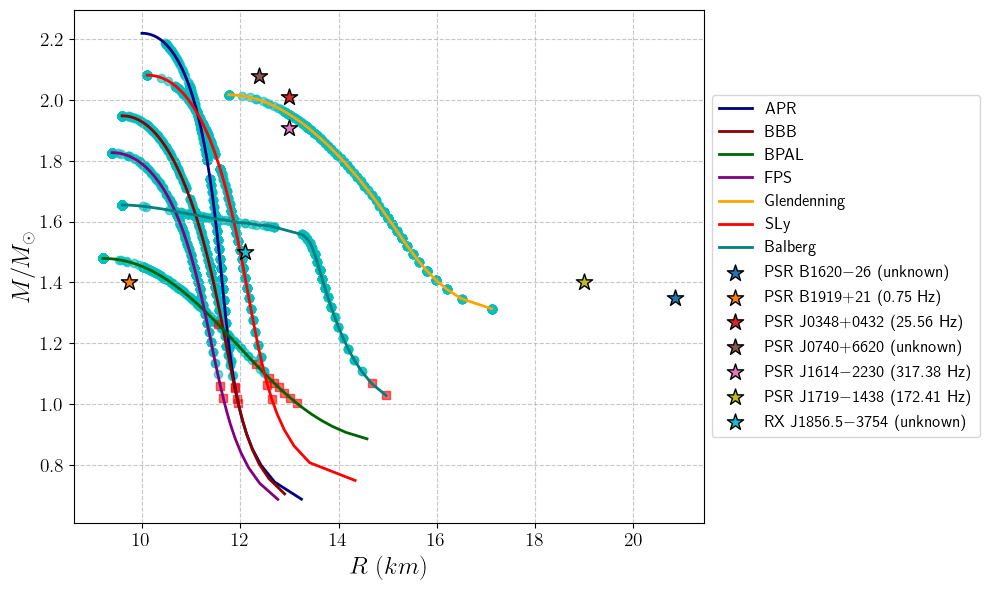

In [38]:
# Define EOS names and colors
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["navy", "darkred", "darkgreen", "purple", "orange", "red", "teal"]

# Columns in MoIL.dat
cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']
mass50, mass90 = [], []

# Extract masses from MoIL.dat using tidal deformability limits
for eos_name in eos_names:
    df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)
    df = df.iloc[:df['M'].idxmax() + 1]

    for _, row in df.iterrows():
        if row['L'] <= 940.45:
            mass50.append(row['M'])
        elif 940.45 < row['L'] <= 1913.8:
            mass90.append(row['M'])

mass50 = np.array(mass50)
mass90 = np.array(mass90)

# Define Lorene data directory and EOS mapping
lorene_directory = "/home/sanjana/ashoka/thesis/lorene_stuff/"
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_4499Hz_nrot_extracted_data.csv",
    "BBB": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_4499Hz_nrot_extracted_data.csv",
    "BPAL": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_4499Hz_nrot_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_4499Hz_nrot_extracted_data.csv",
    "Glendenning": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_4499Hz_nrot_extracted_data.csv",
    "SLy": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_4499Hz_nrot_extracted_data.csv",
    "Balberg": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_4499Hz_nrot_extracted_data.csv"
}

# Columns to extract: Mass and Radius
cols = ["Gravitational mass", "Mean radius"]
mass50_nearest, mass90_nearest = {}, {}
radius50_nearest, radius90_nearest = {}, {}

plt.figure(figsize=(10, 6))

for eos, file in eos_files_stationary.items():
    if not os.path.exists(file):
        print(f"Warning: File not found for {eos}: {file}")
        continue

    df = pd.read_csv(file, usecols=cols).dropna()
    mass_values_raw = df["Gravitational mass"].values
    radius_values_raw = df["Mean radius"].values

    # Enforce monotonic increase in mass
    valid_indices = [0]
    for i in range(1, len(mass_values_raw)):
        if mass_values_raw[i] > mass_values_raw[valid_indices[-1]]:
            valid_indices.append(i)

    mass_values = mass_values_raw[valid_indices]
    radius_values = radius_values_raw[valid_indices]

    color = colors[list(eos_files_stationary.keys()).index(eos)]
    plt.plot(radius_values, mass_values, linestyle="-", color=color, linewidth=2, label=eos)

    # Match constrained masses
    nearest_mass50 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass50]
    nearest_mass90 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass90]
    nearest_mass90 = np.array(list(set(nearest_mass90) - set(nearest_mass50)))  # Avoid overlaps

    corresponding_radius50 = [radius_values[np.abs(mass_values - m).argmin()] for m in nearest_mass50]
    corresponding_radius90 = [radius_values[np.abs(mass_values - m).argmin()] for m in nearest_mass90]

    mass50_nearest[eos] = np.array(nearest_mass50)
    mass90_nearest[eos] = np.array(nearest_mass90)
    radius50_nearest[eos] = np.array(corresponding_radius50)
    radius90_nearest[eos] = np.array(corresponding_radius90)

# Scatter plot of GW170817 constraints
for eos in eos_files_stationary.keys():
    if eos in mass50_nearest:
        plt.scatter(radius50_nearest[eos],mass50_nearest[eos], color="c", marker="o", alpha=0.6)
    if eos in mass90_nearest:
        plt.scatter(radius90_nearest[eos],mass90_nearest[eos], color="r", marker="s", alpha=0.6)

masses_ns = np.array([1.35, 1.4, 2.01, 2.08, 1.908, 1.4, 1.5])
radii_ns = np.array([20.85, 9.7398, 13.0, 12.39, 13.0, 19.0, 12.1])
spin_s_ns = np.array([0, 1.3373, 0.0391226569017806, 0, 0.0031508076534271, 0.0058, 0])
labels_ns = np.array([
    "PSR B1620−26",
    "PSR B1919+21",
    "PSR J0348+0432",
    "PSR J0740+6620",
    "PSR J1614−2230",
    "PSR J1719−1438",
    "RX J1856.5−3754"
])

# Compute frequency in Hz and angular velocity (omega)
freq_ns = np.where(spin_s_ns != 0, 1 / spin_s_ns, 0)
omega_ns = 2 * np.pi * freq_ns

# Colormap for different stars
num_stars = len(labels_ns)
colors_ns = cm.get_cmap("tab10", num_stars)

for i, (radius, mass, label, freq) in enumerate(zip(radii_ns, masses_ns, labels_ns, freq_ns)):
    label_with_freq = f"{label} ({freq:.2f} Hz)" if freq > 0 else f"{label} (unknown)"
    plt.scatter(
        radius, mass,
        color=colors_ns(i),
        marker="*",
        s=150,
        edgecolors='black',
        linewidth=1,
        label=label_with_freq,
        zorder=10
    )

# Final formatting
plt.ylabel(r'$M/M_\odot$', fontsize=18)
plt.xlabel(r'$R \ (km)$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("Mass_Radius_with_constraints_2.png", dpi=300)
plt.show()

## Final MOI plot with constraints

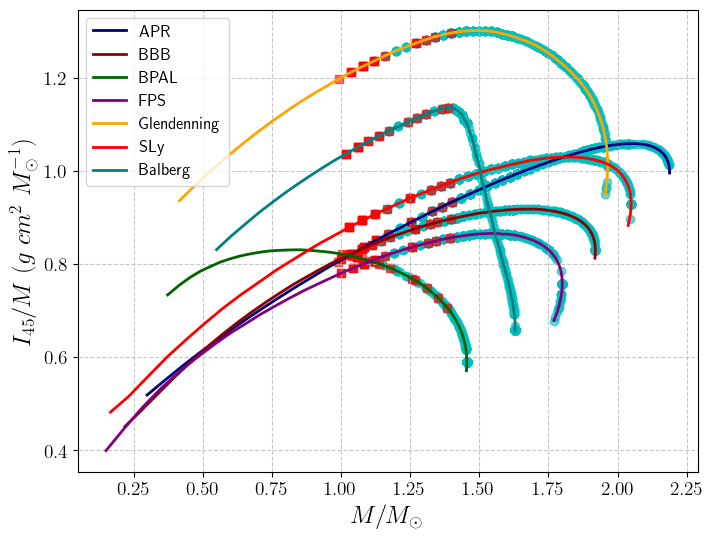

In [12]:
# -------------------------------------------------------------------------------------------------
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["navy", "darkred", "darkgreen", "purple", "orange", "red", "teal"]
cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']  # Column names
mass50 = []  # Stores masses for 50% probability bound
mass90 = []  # Stores masses for 90% probability bound

for i, eos_name in enumerate(eos_names):
    df = pd.read_csv(f'../output/{eos_name}/MoIL.dat', names=cols)

    # Find index of maximum mass and truncate data
    max_mass_idx = df['M'].idxmax()
    df = df.iloc[:max_mass_idx + 1]

    # Extract mass values for GW170817 constraints
    for j in range(len(df.M)):
        if df.L[j] <= 940.45:  # 50% Probability
            mass50.append(df.M[j])
        elif 940.45 < df.L[j] <= 1913.8:  # 90% Probability
            mass90.append(df.M[j])

# Convert lists to numpy arrays
mass50 = np.array(mass50)
mass90 = np.array(mass90)
###################################################################################################

# Base directory for EOS files
lorene_directory = "/home/sanjana/ashoka/thesis/lorene_stuff/"

# EOS file mapping for 300Hz neutron stars
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_300Hz_extracted_data.csv",
    "BBB": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_300Hz_extracted_data.csv",
    "BPAL": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_300Hz_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "Glendenning": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_300Hz_extracted_data.csv",
    "SLy": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "Balberg": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_300Hz_extracted_data.csv"
}

# Column names for the CSV files
cols = ["Gravitational mass", "Moment of inertia"]

# Dictionaries to store results
mass50_nearest = {}
mass90_nearest = {}
moi50_nearest = {}
moi90_nearest = {}

plt.figure(figsize=(8, 6))

# Loop through each EOS file
for eos, file in eos_files_stationary.items():
    if not os.path.exists(file):
        print(f"Warning: File not found for {eos}: {file}")
        continue  # Skip missing files

    # Read the required columns
    df = pd.read_csv(file, usecols=cols).dropna()

    # Get color for the current EOS
    color = colors[list(eos_files_stationary.keys()).index(eos)]  # Matching EOS to color list
    
    plt.plot(df["Gravitational mass"], df["Moment of inertia"]/df["Gravitational mass"], 
             linestyle="-", color=color, linewidth=2, label=eos)  # Remove markersize

    # Extract mass and MoI values
    mass_values = df["Gravitational mass"].values
    moi_values = df["Moment of inertia"].values/df["Gravitational mass"].values

    # Find the nearest mass values for mass50 and mass90
    nearest_mass50 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass50]
    nearest_mass90 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass90]

    # Find the corresponding MoI values
    corresponding_moi50 = [moi_values[np.abs(mass_values - m).argmin()] for m in nearest_mass50]
    corresponding_moi90 = [moi_values[np.abs(mass_values - m).argmin()] for m in nearest_mass90]

    # Store results
    mass50_nearest[eos] = np.array(nearest_mass50)
    mass90_nearest[eos] = np.array(nearest_mass90)
    moi50_nearest[eos] = np.array(corresponding_moi50)
    moi90_nearest[eos] = np.array(corresponding_moi90)

# --- Plotting MoI vs Mass for 50% and 90% Probability ---

for eos in eos_files_stationary.keys():
    if eos in mass50_nearest and eos in moi50_nearest:
        plt.scatter(mass50_nearest[eos], moi50_nearest[eos], color="c", marker="o", alpha=0.6)
    
    if eos in mass90_nearest and eos in moi90_nearest:
        plt.scatter(mass90_nearest[eos], moi90_nearest[eos], color="r", marker="s", alpha=0.6)

plt.xlabel(r'$M/M_\odot$', fontsize=18)
plt.ylabel(r'$I_{45}/M \ (g \ cm^2 \ M_{\odot}^{-1})$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.savefig("MOI_with_constraints.png", dpi=300)
plt.show()

## separating 50 and 90 %

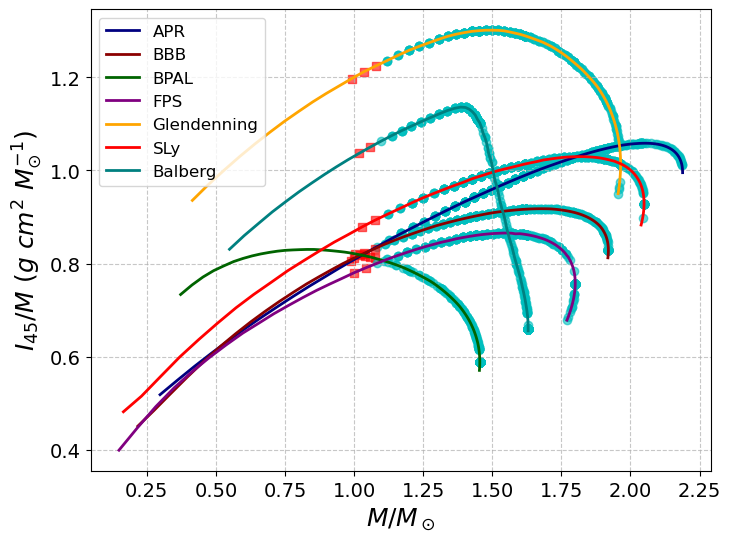

In [9]:
# -------------------------------------------------------------------------------------------------
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["navy", "darkred", "darkgreen", "purple", "orange", "red", "teal"]
cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']  # Column names
mass50 = []  # Stores masses for 50% probability bound
mass90 = []  # Stores masses for 90% probability bound

for i, eos_name in enumerate(eos_names):
    df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)

    # Find index of maximum mass and truncate data
    max_mass_idx = df['M'].idxmax()
    df = df.iloc[:max_mass_idx + 1]

    # Extract mass values for GW170817 constraints
    for j in range(len(df.M)):
        if df.L[j] <= 940.45:  # 50% Probability
            mass50.append(df.M[j])
        elif 940.45 < df.L[j] <= 1913.8:  # 90% Probability
            mass90.append(df.M[j])

# Convert lists to numpy arrays
mass50 = np.array(mass50)
mass90 = np.array(mass90)
###################################################################################################

# Base directory for EOS files
lorene_directory = "/home/sanjana/ashoka/thesis/lorene_stuff/"

# EOS file mapping for 300Hz neutron stars
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_300Hz_extracted_data.csv",
    "BBB": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_300Hz_extracted_data.csv",
    "BPAL": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_300Hz_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "Glendenning": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_300Hz_extracted_data.csv",
    "SLy": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "Balberg": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_300Hz_extracted_data.csv"
}

# Column names for the CSV files
cols = ["Gravitational mass", "Moment of inertia"]

# Dictionaries to store results
mass50_nearest = {}
mass90_nearest = {}
moi50_nearest = {}
moi90_nearest = {}

plt.figure(figsize=(8, 6))

# Loop through each EOS file
for eos, file in eos_files_stationary.items():
    if not os.path.exists(file):
        print(f"Warning: File not found for {eos}: {file}")
        continue  # Skip missing files

    # Read the required columns
    df = pd.read_csv(file, usecols=cols).dropna()

    # Get color for the current EOS
    color = colors[list(eos_files_stationary.keys()).index(eos)]  # Matching EOS to color list
    
    plt.plot(df["Gravitational mass"], df["Moment of inertia"]/df["Gravitational mass"], 
             linestyle="-", color=color, linewidth=2, label=eos)  # Remove markersize

    # Extract mass and MoI values
    mass_values = df["Gravitational mass"].values
    moi_values = df["Moment of inertia"].values/df["Gravitational mass"].values

    # Find the nearest mass values for mass50 and mass90
    nearest_mass50 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass50]
    nearest_mass90 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass90]
    nearest_mass90 = np.array(list(set(nearest_mass90) - set(nearest_mass50)))

    # Find the corresponding MoI values
    corresponding_moi50 = [moi_values[np.abs(mass_values - m).argmin()] for m in nearest_mass50]
    corresponding_moi90 = [moi_values[np.abs(mass_values - m).argmin()] for m in nearest_mass90]

    # Store results
    mass50_nearest[eos] = np.array(nearest_mass50)
    mass90_nearest[eos] = np.array(nearest_mass90)
    moi50_nearest[eos] = np.array(corresponding_moi50)
    moi90_nearest[eos] = np.array(corresponding_moi90)

# --- Plotting MoI vs Mass for 50% and 90% Probability ---

for eos in eos_files_stationary.keys():
    if eos in mass50_nearest and eos in moi50_nearest:
        plt.scatter(mass50_nearest[eos], moi50_nearest[eos], color="c", marker="o", alpha=0.6)
    
    if eos in mass90_nearest and eos in moi90_nearest:
        plt.scatter(mass90_nearest[eos], moi90_nearest[eos], color="r", marker="s", alpha=0.6)

plt.xlabel(r'$M/M_\odot$', fontsize=18)
plt.ylabel(r'$I_{45}/M \ (g \ cm^2 \ M_{\odot}^{-1})$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.savefig("MOI_with_constraints.png", dpi=300)
plt.show()

## ?

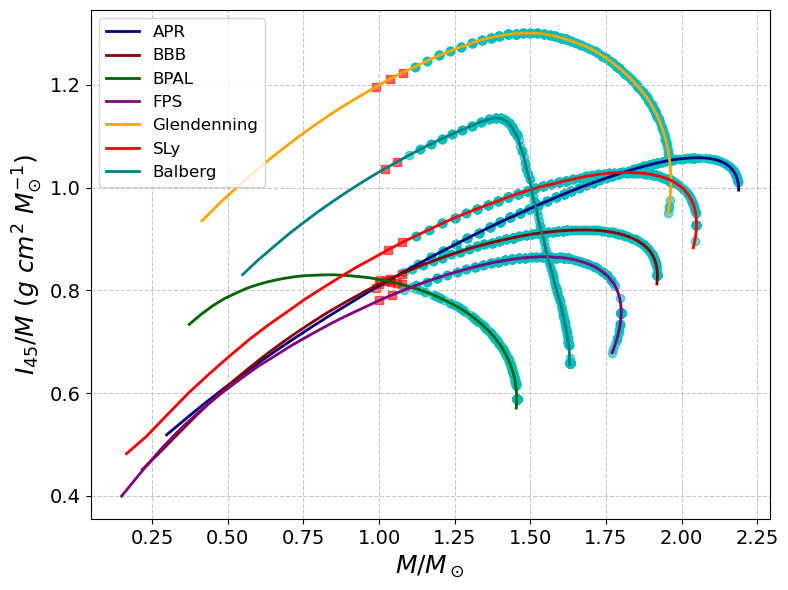

In [12]:
# -------------------------------------------------------------------------------------------------
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define EOS names and their plotting colors
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["navy", "darkred", "darkgreen", "purple", "orange", "red", "teal"]

# Column names in MoIL.dat
cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']  

# Lists to store mass values satisfying 50% and 90% GW170817 bounds
mass50 = []
mass90 = []

# --- Extract masses from MoIL.dat within GW170817 tidal deformability constraints ---
for eos_name in eos_names:
    df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)

    # Truncate data up to maximum mass point
    df = df.iloc[:df['M'].idxmax() + 1]

    # Loop through rows and append qualifying masses
    for _, row in df.iterrows():
        if row['L'] <= 940.45:  # 50% bound
            mass50.append(row['M'])
        elif 940.45 < row['L'] <= 1913.8:  # 90% bound
            mass90.append(row['M'])

# Convert to numpy arrays
mass50 = np.array(mass50)
mass90 = np.array(mass90)
# -------------------------------------------------------------------------------------------------

# Base directory for LORENE output
lorene_directory = "/home/sanjana/ashoka/thesis/lorene_stuff/"

# EOS mapping to stationary neutron star CSV files at 300Hz
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_300Hz_extracted_data.csv",
    "BBB": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_300Hz_extracted_data.csv",
    "BPAL": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_300Hz_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "Glendenning": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_300Hz_extracted_data.csv",
    "SLy": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_300Hz_extracted_data.csv",
    "Balberg": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_300Hz_extracted_data.csv"
}

# Required column names from CSVs
cols = ["Gravitational mass", "Moment of inertia"]

# Dictionaries to store nearest matches to mass50 and mass90, and corresponding MoI values
mass50_nearest, mass90_nearest = {}, {}
moi50_nearest, moi90_nearest = {}, {}

# Initialize plot
plt.figure(figsize=(8, 6))

# Loop over each EOS to extract MoI data and match constrained masses
for eos, filepath in eos_files_stationary.items():
    if not os.path.exists(filepath):
        print(f"Warning: Missing file for EOS '{eos}': {filepath}")
        continue

    df = pd.read_csv(filepath, usecols=cols).dropna()
    
    # Assign consistent color for plotting
    color = colors[list(eos_files_stationary.keys()).index(eos)]

    # Compute I/M and plot curve
    mass_vals = df["Gravitational mass"].values
    moi_vals = df["Moment of inertia"].values / mass_vals
    plt.plot(mass_vals, moi_vals, linestyle="-", color=color, linewidth=2, label=eos)

    # Find nearest mass values in the table for GW-constrained masses
    nearest50 = [mass_vals[np.abs(mass_vals - m).argmin()] for m in mass50]
    nearest90 = [mass_vals[np.abs(mass_vals - m).argmin()] for m in mass90]
    # Exclude overlaps with 50% set to avoid duplication
    nearest90 = list(set(nearest90) - set(nearest50))

    # Find corresponding MoI values
    moi_50 = [moi_vals[np.abs(mass_vals - m).argmin()] for m in nearest50]
    moi_90 = [moi_vals[np.abs(mass_vals - m).argmin()] for m in nearest90]

    # Store results
    mass50_nearest[eos] = np.array(nearest50)
    moi50_nearest[eos] = np.array(moi_50)
    mass90_nearest[eos] = np.array(nearest90)
    moi90_nearest[eos] = np.array(moi_90)

# --- Overlay scatter plots for 50% and 90% constraints ---

for eos in eos_files_stationary.keys():
    if eos in mass50_nearest:
        plt.scatter(mass50_nearest[eos], moi50_nearest[eos], color="c", marker="o", alpha=0.6)

    if eos in mass90_nearest:
        plt.scatter(mass90_nearest[eos], moi90_nearest[eos], color="r", marker="s", alpha=0.6)

# --- Final plot formatting ---
plt.xlabel(r'$M/M_\odot$', fontsize=18)
plt.ylabel(r'$I_{45}/M \ (g \ cm^2 \ M_{\odot}^{-1})$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("MOI_with_constraints.png", dpi=300)
plt.show()

## Removing unphysical scenarios above max mass

<>:204: SyntaxWarning: invalid escape sequence '\%'
<>:206: SyntaxWarning: invalid escape sequence '\%'
<>:204: SyntaxWarning: invalid escape sequence '\%'
<>:206: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_4150699/2802463753.py:204: SyntaxWarning: invalid escape sequence '\%'
  Line2D([0], [0], marker='o', color='w', label='50\% confidence interval',
/tmp/ipykernel_4150699/2802463753.py:206: SyntaxWarning: invalid escape sequence '\%'
  Line2D([0], [0], marker='s', color='w', label='90\% confidence interval',


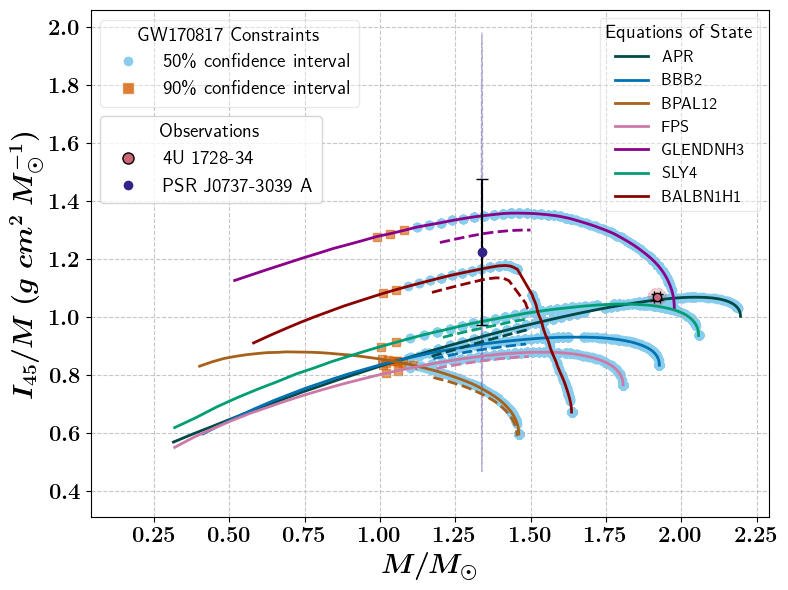

In [41]:
# -------------------------------------------------------------------------------------------------
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define EOS names and their plotting colors
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["#004949", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B",  "#009E73", "#8B0000"]

# Column names in MoIL.dat
cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']  

# Lists to store mass values satisfying 50% and 90% GW170817 bounds
mass50 = []
mass90 = []

# --- Extract masses from MoIL.dat within GW170817 tidal deformability constraints ---
for eos_name in eos_names:
    df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)

    # Truncate data up to maximum mass point
    df = df.iloc[:df['M'].idxmax() + 1]

    # Loop through rows and append qualifying masses
    for _, row in df.iterrows():
        if row['L'] <= 940.45:  # 50% bound
            mass50.append(row['M'])
        elif 940.45 < row['L'] <= 1913.8:  # 90% bound
            mass90.append(row['M'])

# Convert to numpy arrays
mass50 = np.array(mass50)
mass90 = np.array(mass90)
# -------------------------------------------------------------------------------------------------

# Base directory for LORENE output
lorene_directory = "/home/sanjana/ashoka/thesis/lorene_stuff/"
# Required column names from CSVs
cols = ["Gravitational mass", "Moment of inertia"]

# EOS mapping to stationary neutron star CSV files at 300Hz
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_363Hz_nrot_extracted_data.csv",
    "BBB2": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_363Hz_nrot_extracted_data.csv",
    "BPAL12": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_363Hz_nrot_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_363Hz_nrot_extracted_data.csv",
    "GLENDNH3": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_363Hz_nrot_extracted_data.csv",
    "SLY4": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_363Hz_nrot_extracted_data.csv",
    "BALBN1H1": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_363Hz_nrot_extracted_data.csv"
}

eos_files_stationary2 = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_44Hz_nrot_extracted_data.csv",
    "BBB2": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_44Hz_nrot_extracted_data.csv",
    "BPAL12": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_44Hz_nrot_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_44Hz_nrot_extracted_data.csv",
    "GLENDNH3": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_44Hz_nrot_extracted_data.csv",
    "SLY4": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_44Hz_nrot_extracted_data.csv",
    "BALBN1H1": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_44Hz_nrot_extracted_data.csv"
}

# Dictionaries to store nearest matches to mass50 and mass90, and corresponding MoI values
mass50_nearest, mass90_nearest = {}, {}
moi50_nearest, moi90_nearest = {}, {}

eos_handles = []

# Initialize plot
plt.figure(figsize=(8, 6))

# Loop over each EOS to extract MoI data and match constrained masses
for eos, file in eos_files_stationary.items():
    if not os.path.exists(file):
        print(f"Warning: File not found for {eos}: {file}")
        continue

    # Read the required columns
    df = pd.read_csv(file, usecols=cols).dropna()

    # Enforce monotonic increase in gravitational mass only
    mass_values_raw = df["Gravitational mass"].values
    moi_values_raw = df["Moment of inertia"].values

    # Identify valid (monotonically increasing) indices
    valid_indices = [0]
    for i in range(1, len(mass_values_raw)):
        if mass_values_raw[i] > mass_values_raw[valid_indices[-1]]:
            valid_indices.append(i)

    # Filtered values
    mass_values = mass_values_raw[valid_indices]
    moi_values = moi_values_raw[valid_indices] / mass_values  # MoI / M only after filtering masses

    color = colors[list(eos_files_stationary.keys()).index(eos)]
    line, = plt.plot(mass_values, moi_values, linestyle="-", color=color, linewidth=2, label=eos)
    eos_handles.append(line)

    # Find nearest mass values for constraints
    nearest_mass50 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass50]
    nearest_mass90 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass90]
    nearest_mass90 = np.array(list(set(nearest_mass90) - set(nearest_mass50)))  # Exclude overlap

    # Corresponding MoI values (note: index from filtered mass_values)
    corresponding_moi50 = [moi_values[np.abs(mass_values - m).argmin()] for m in nearest_mass50]
    corresponding_moi90 = [moi_values[np.abs(mass_values - m).argmin()] for m in nearest_mass90]

    # Store results
    mass50_nearest[eos] = np.array(nearest_mass50)
    mass90_nearest[eos] = np.array(nearest_mass90)
    moi50_nearest[eos] = np.array(corresponding_moi50)
    moi90_nearest[eos] = np.array(corresponding_moi90)
    
# --- Overlay scatter plots for 50% and 90% constraints ---

for eos in eos_files_stationary.keys():
    if eos in mass50_nearest:
        plt.scatter(mass50_nearest[eos], moi50_nearest[eos], color="#88CCEE", marker="o")

    if eos in mass90_nearest:
        plt.scatter(mass90_nearest[eos], moi90_nearest[eos], color="#D55E00", marker="s", alpha=0.6)

# Add your point with error bars
M_star = 1.92
dM = 0.01
I45_M = 1.07
dI = 0.01

# Plot the first point
plt.errorbar(M_star, I45_M, xerr=dM, yerr=dI, fmt='o', color='#CC6677', markeredgecolor='black', ecolor='black',
             elinewidth=1.5, capsize=4, label='4U 1728-34')

# Confidence ellipses: 1σ and 3σ with same color and adjusted transparency
for n, alpha, color in zip([1, 3], [0.5, 0.3], ['#CC6677', '#CC6677']):
    ell = Ellipse((M_star, I45_M), width=2*n*dM, height=2*n*dI,
                  edgecolor=color, facecolor=color, alpha=alpha, linestyle='--', linewidth=1)
    plt.gca().add_patch(ell)

# New NS data
M_ns = 1.3381
dM_ns = 0.0007
I_ns_min = 1.30/M_ns
I_ns_max = 1.976/M_ns
I_ns_mid = (I_ns_min + I_ns_max) / 2
dI_ns = (I_ns_max - I_ns_min) / 2

# Plot the second point
plt.errorbar(M_ns, I_ns_mid, xerr=dM_ns, yerr=dI_ns,
             fmt='o', color='#332288', ecolor='k',
             elinewidth=1.5, capsize=4, label='PSR J0737-3039 A')

# Confidence ellipses: 1σ and 3σ with same color and adjusted transparency
for n, alpha, color in zip([1, 3], [0.5, 0.3], ['#332288', '#332288']):
    ell = Ellipse((M_ns, I_ns_mid), width=2*n*dM_ns, height=2*n*dI_ns,
                  edgecolor=color, facecolor=color, alpha=alpha, linestyle='--', linewidth=1)
    plt.gca().add_patch(ell)

eos_handles_44 = []
# --- Add 44 Hz curves for mass range 1.17 to 1.5 ---
for eos, file in eos_files_stationary2.items():
    if not os.path.exists(file):
        print(f"Warning: 44Hz File not found for {eos}: {file}")
        continue

    df = pd.read_csv(file, usecols=cols).dropna()

    mass_values_raw = df["Gravitational mass"].values
    moi_values_raw = df["Moment of inertia"].values

    # Ensure monotonic mass increase
    valid_indices = [0]
    for i in range(1, len(mass_values_raw)):
        if mass_values_raw[i] > mass_values_raw[valid_indices[-1]]:
            valid_indices.append(i)

    mass_values = mass_values_raw[valid_indices]
    moi_values = moi_values_raw[valid_indices] / mass_values

    # Restrict to mass range 1.17 to 1.5 Msun
    mask = (mass_values >= 1.17) & (mass_values <= 1.5)
    mass_filtered = mass_values[mask]
    moi_filtered = moi_values[mask]

    # Use the same color but dashed line for 44 Hz
    color = colors[list(eos_files_stationary2.keys()).index(eos)]
    line44, = plt.plot(mass_filtered, moi_filtered, linestyle="--", color=color, linewidth=2)
    eos_handles_44.append(line44)

# --- Final plot formatting ---
plt.xlabel(r'$M/M_\odot$', fontsize=20)
plt.ylabel(r'$I_{45}/M \ (g \ cm^2 \ M_{\odot}^{-1})$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)

first_legend = plt.legend(handles=eos_handles, title="Equations of State", fontsize=12, loc='upper right', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)

#first_legend_44 = plt.legend(handles=eos_handles_44, title="Equations of State", fontsize=12, loc='upper right', bbox_to_anchor=(1, 0.6), title_fontsize=14,framealpha=0.4)
#plt.gca().add_artist(first_legend_44)

gw_handles = [
    Line2D([0], [0], marker='o', color='w', label='50\% confidence interval',
           markerfacecolor='#88CCEE', markersize=8),
    Line2D([0], [0], marker='s', color='w', label='90\% confidence interval',
           markerfacecolor='#D55E00', markersize=8, alpha=0.8)
]
# Add second legend for GW170817 Constraints
second_legend = plt.legend(handles=gw_handles, title="GW170817 Constraints",
                           loc='upper left', fontsize=14, title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(second_legend)

obs_handles = [
    Line2D([0], [0], marker='o', color='w', label='4U 1728-34',
           markerfacecolor='#CC6677', markeredgecolor='black', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='PSR J0737-3039 A',
           markerfacecolor='#332288', markersize=8)
]

obs_labels = ['4U 1728-34', 'PSR J0737-3039 A']

# Add third legend for Observations
third_legend = plt.legend(handles=obs_handles, labels=obs_labels, title="Observations", 
                          fontsize=14, loc='lower left', bbox_to_anchor=(0, 0.6), title_fontsize=14)
'''
# Get current axes
ax = plt.gca()

# Get limits
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

print("X range:", x_min, "to", x_max)
print("Y range:", y_min, "to", y_max)
'''
plt.xlim(0.04, 2.29)
plt.ylim(0.31, 2.06)
plt.tight_layout()
#plt.savefig("MOI_with_obs_constraints.png", dpi=300)
plt.savefig("/home/sanjana/ashoka/thesis/finalplots/MOI_with_obs_constraints.pdf")
plt.savefig("/home/sanjana/ashoka/thesis/finalplots/MOI_with_obs_constraints.png",dpi=600)
plt.show()

<>:127: SyntaxWarning: invalid escape sequence '\%'
<>:129: SyntaxWarning: invalid escape sequence '\%'
<>:127: SyntaxWarning: invalid escape sequence '\%'
<>:129: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_4150699/3752627330.py:127: SyntaxWarning: invalid escape sequence '\%'
  Line2D([0], [0], marker='o', color='w', label='50\% confidence interval',
/tmp/ipykernel_4150699/3752627330.py:129: SyntaxWarning: invalid escape sequence '\%'
  Line2D([0], [0], marker='s', color='w', label='90\% confidence interval',


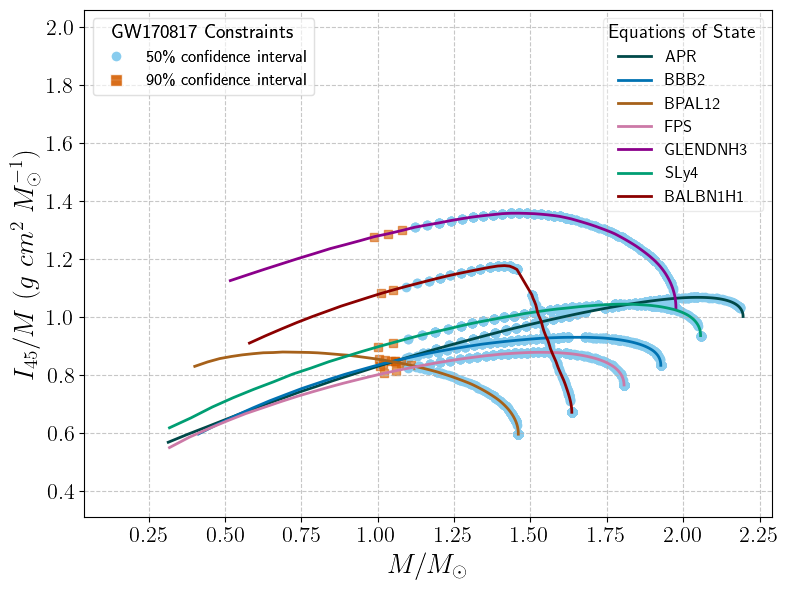

In [8]:
# -------------------------------------------------------------------------------------------------
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define EOS names and their plotting colors
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["#004949", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B",  "#009E73", "#8B0000"]

# Column names in MoIL.dat
cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']  

# Lists to store mass values satisfying 50% and 90% GW170817 bounds
mass50 = []
mass90 = []

# --- Extract masses from MoIL.dat within GW170817 tidal deformability constraints ---
for eos_name in eos_names:
    df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)

    # Truncate data up to maximum mass point
    df = df.iloc[:df['M'].idxmax() + 1]

    # Loop through rows and append qualifying masses
    for _, row in df.iterrows():
        if row['L'] <= 940.45:  # 50% bound
            mass50.append(row['M'])
        elif 940.45 < row['L'] <= 1913.8:  # 90% bound
            mass90.append(row['M'])

# Convert to numpy arrays
mass50 = np.array(mass50)
mass90 = np.array(mass90)
# -------------------------------------------------------------------------------------------------

# Base directory for LORENE output
lorene_directory = "/home/sanjana/ashoka/thesis/lorene_stuff/"

# EOS mapping to stationary neutron star CSV files at 300Hz
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_363Hz_nrot_extracted_data.csv",
    "BBB2": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_363Hz_nrot_extracted_data.csv",
    "BPAL12": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_363Hz_nrot_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_363Hz_nrot_extracted_data.csv",
    "GLENDNH3": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_363Hz_nrot_extracted_data.csv",
    "SLy4": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_363Hz_nrot_extracted_data.csv",
    "BALBN1H1": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_363Hz_nrot_extracted_data.csv"
}

# Required column names from CSVs
cols = ["Gravitational mass", "Moment of inertia"]

# Dictionaries to store nearest matches to mass50 and mass90, and corresponding MoI values
mass50_nearest, mass90_nearest = {}, {}
moi50_nearest, moi90_nearest = {}, {}

eos_handles = []

# Initialize plot
plt.figure(figsize=(8, 6))

# Loop over each EOS to extract MoI data and match constrained masses
for eos, file in eos_files_stationary.items():
    if not os.path.exists(file):
        print(f"Warning: File not found for {eos}: {file}")
        continue

    # Read the required columns
    df = pd.read_csv(file, usecols=cols).dropna()

    # Enforce monotonic increase in gravitational mass only
    mass_values_raw = df["Gravitational mass"].values
    moi_values_raw = df["Moment of inertia"].values

    # Identify valid (monotonically increasing) indices
    valid_indices = [0]
    for i in range(1, len(mass_values_raw)):
        if mass_values_raw[i] > mass_values_raw[valid_indices[-1]]:
            valid_indices.append(i)

    # Filtered values
    mass_values = mass_values_raw[valid_indices]
    moi_values = moi_values_raw[valid_indices] / mass_values  # MoI / M only after filtering masses

    color = colors[list(eos_files_stationary.keys()).index(eos)]
    line, = plt.plot(mass_values, moi_values, linestyle="-", color=color, linewidth=2, label=eos)
    eos_handles.append(line)

    # Find nearest mass values for constraints
    nearest_mass50 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass50]
    nearest_mass90 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass90]
    nearest_mass90 = np.array(list(set(nearest_mass90) - set(nearest_mass50)))  # Exclude overlap

    # Corresponding MoI values (note: index from filtered mass_values)
    corresponding_moi50 = [moi_values[np.abs(mass_values - m).argmin()] for m in nearest_mass50]
    corresponding_moi90 = [moi_values[np.abs(mass_values - m).argmin()] for m in nearest_mass90]

    # Store results
    mass50_nearest[eos] = np.array(nearest_mass50)
    mass90_nearest[eos] = np.array(nearest_mass90)
    moi50_nearest[eos] = np.array(corresponding_moi50)
    moi90_nearest[eos] = np.array(corresponding_moi90)
    
# --- Overlay scatter plots for 50% and 90% constraints ---

for eos in eos_files_stationary.keys():
    if eos in mass50_nearest:
        plt.scatter(mass50_nearest[eos], moi50_nearest[eos], color="#88CCEE", marker="o")

    if eos in mass90_nearest:
        plt.scatter(mass90_nearest[eos], moi90_nearest[eos], color="#D55E00", marker="s", alpha=0.6)

# --- Final plot formatting ---
plt.xlabel(r'$M/M_\odot$', fontsize=20)
plt.ylabel(r'$I_{45}/M \ (g \ cm^2 \ M_{\odot}^{-1})$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)

first_legend = plt.legend(handles=eos_handles, title="Equations of State", fontsize=12, loc='upper right', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)

# Add second legend for GW170817 Constraints
gw_handles = [
    Line2D([0], [0], marker='o', color='w', label='50\% confidence interval',
           markerfacecolor='#88CCEE', markersize=8),
    Line2D([0], [0], marker='s', color='w', label='90\% confidence interval',
           markerfacecolor='#D55E00', markersize=8, alpha=0.8)
]
# Add second legend for GW170817 Constraints
second_legend = plt.legend(handles=gw_handles, title="GW170817 Constraints",
                           loc='upper left', fontsize=12, title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(second_legend)

plt.xlim(0.04, 2.29)
plt.ylim(0.31, 2.06)
plt.tight_layout()
#plt.savefig("MOI_with_obs_constraints.png", dpi=300)
#plt.savefig("/home/sanjana/ashoka/thesis/finalplots/MOI_with_gw_constraints.pdf")
plt.savefig("/home/sanjana/ashoka/thesis/finalplots/MOI_with_gw_constraints.png",dpi=600)
plt.show()

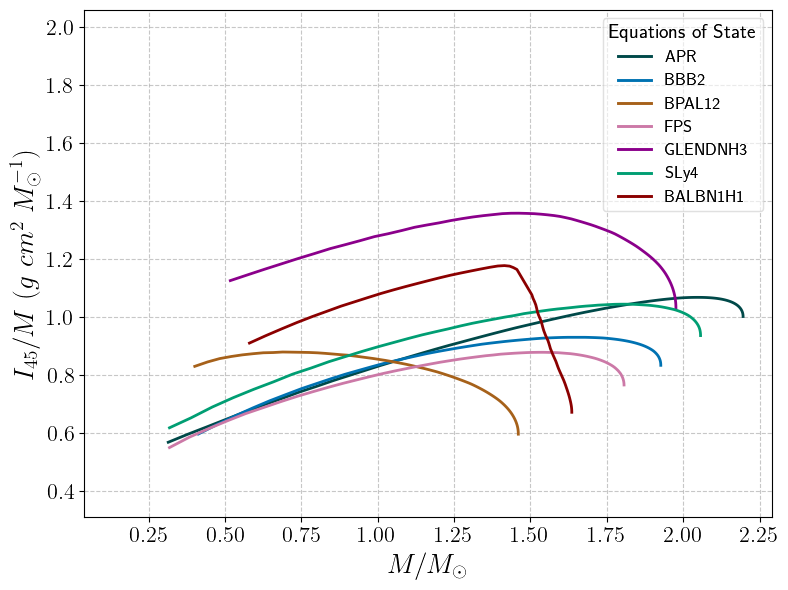

In [9]:
# -------------------------------------------------------------------------------------------------
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define EOS names and their plotting colors
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["#004949", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B",  "#009E73", "#8B0000"]

# Column names in MoIL.dat
cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']  

# Lists to store mass values satisfying 50% and 90% GW170817 bounds
mass50 = []
mass90 = []

# --- Extract masses from MoIL.dat within GW170817 tidal deformability constraints ---
for eos_name in eos_names:
    df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)

    # Truncate data up to maximum mass point
    df = df.iloc[:df['M'].idxmax() + 1]

    # Loop through rows and append qualifying masses
    for _, row in df.iterrows():
        if row['L'] <= 940.45:  # 50% bound
            mass50.append(row['M'])
        elif 940.45 < row['L'] <= 1913.8:  # 90% bound
            mass90.append(row['M'])

# Convert to numpy arrays
mass50 = np.array(mass50)
mass90 = np.array(mass90)
# -------------------------------------------------------------------------------------------------

# Base directory for LORENE output
lorene_directory = "/home/sanjana/ashoka/thesis/lorene_stuff/"

# EOS mapping to stationary neutron star CSV files at 300Hz
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_363Hz_nrot_extracted_data.csv",
    "BBB2": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_363Hz_nrot_extracted_data.csv",
    "BPAL12": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_363Hz_nrot_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_363Hz_nrot_extracted_data.csv",
    "GLENDNH3": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_363Hz_nrot_extracted_data.csv",
    "SLy4": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_363Hz_nrot_extracted_data.csv",
    "BALBN1H1": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_363Hz_nrot_extracted_data.csv"
}

# Required column names from CSVs
cols = ["Gravitational mass", "Moment of inertia"]

# Dictionaries to store nearest matches to mass50 and mass90, and corresponding MoI values
mass50_nearest, mass90_nearest = {}, {}
moi50_nearest, moi90_nearest = {}, {}

eos_handles = []

# Initialize plot
plt.figure(figsize=(8, 6))

# Loop over each EOS to extract MoI data and match constrained masses
for eos, file in eos_files_stationary.items():
    if not os.path.exists(file):
        print(f"Warning: File not found for {eos}: {file}")
        continue

    # Read the required columns
    df = pd.read_csv(file, usecols=cols).dropna()

    # Enforce monotonic increase in gravitational mass only
    mass_values_raw = df["Gravitational mass"].values
    moi_values_raw = df["Moment of inertia"].values

    # Identify valid (monotonically increasing) indices
    valid_indices = [0]
    for i in range(1, len(mass_values_raw)):
        if mass_values_raw[i] > mass_values_raw[valid_indices[-1]]:
            valid_indices.append(i)

    # Filtered values
    mass_values = mass_values_raw[valid_indices]
    moi_values = moi_values_raw[valid_indices] / mass_values  # MoI / M only after filtering masses

    color = colors[list(eos_files_stationary.keys()).index(eos)]
    line, = plt.plot(mass_values, moi_values, linestyle="-", color=color, linewidth=2, label=eos)
    eos_handles.append(line)

    # Find nearest mass values for constraints
    nearest_mass50 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass50]
    nearest_mass90 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass90]
    nearest_mass90 = np.array(list(set(nearest_mass90) - set(nearest_mass50)))  # Exclude overlap

    # Corresponding MoI values (note: index from filtered mass_values)
    corresponding_moi50 = [moi_values[np.abs(mass_values - m).argmin()] for m in nearest_mass50]
    corresponding_moi90 = [moi_values[np.abs(mass_values - m).argmin()] for m in nearest_mass90]

    # Store results
    mass50_nearest[eos] = np.array(nearest_mass50)
    mass90_nearest[eos] = np.array(nearest_mass90)
    moi50_nearest[eos] = np.array(corresponding_moi50)
    moi90_nearest[eos] = np.array(corresponding_moi90)
    
# --- Final plot formatting ---
plt.xlabel(r'$M/M_\odot$', fontsize=20)
plt.ylabel(r'$I_{45}/M \ (g \ cm^2 \ M_{\odot}^{-1})$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)

first_legend = plt.legend(handles=eos_handles, title="Equations of State", fontsize=12, loc='upper right', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)

plt.xlim(0.04, 2.29)
plt.ylim(0.31, 2.06)
plt.tight_layout()
#plt.savefig("MOI_with_obs_constraints.png", dpi=300)
#plt.savefig("/home/sanjana/ashoka/thesis/finalplots/MOI_with_no_constraints.pdf")
plt.savefig("/home/sanjana/ashoka/thesis/finalplots/MOI_with_no_constraints.png",dpi=600)
plt.show()

## Constraints on Higher Rotational Case

<>:162: SyntaxWarning: invalid escape sequence '\%'
<>:164: SyntaxWarning: invalid escape sequence '\%'
<>:162: SyntaxWarning: invalid escape sequence '\%'
<>:164: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_4150699/2273194097.py:162: SyntaxWarning: invalid escape sequence '\%'
  Line2D([0], [0], marker='o', color='w', label='50\% confidence interval',
/tmp/ipykernel_4150699/2273194097.py:164: SyntaxWarning: invalid escape sequence '\%'
  Line2D([0], [0], marker='s', color='w', label='90\% confidence interval',


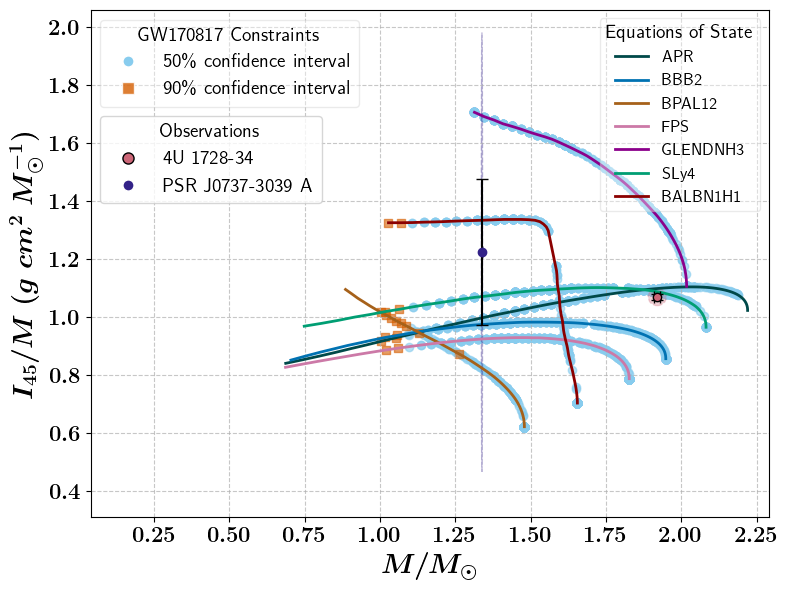

In [36]:
# -------------------------------------------------------------------------------------------------
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define EOS names and their plotting colors
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["#004949", "#0072B2",  "#A6611A", "#CC79A7", "#8B008B",  "#009E73", "#8B0000"]

# Column names in MoIL.dat
cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']  

# Lists to store mass values satisfying 50% and 90% GW170817 bounds
mass50 = []
mass90 = []

# --- Extract masses from MoIL.dat within GW170817 tidal deformability constraints ---
for eos_name in eos_names:
    df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)

    # Truncate data up to maximum mass point
    df = df.iloc[:df['M'].idxmax() + 1]

    # Loop through rows and append qualifying masses
    for _, row in df.iterrows():
        if row['L'] <= 940.45:  # 50% bound
            mass50.append(row['M'])
        elif 940.45 < row['L'] <= 1913.8:  # 90% bound
            mass90.append(row['M'])

# Convert to numpy arrays
mass50 = np.array(mass50)
mass90 = np.array(mass90)
# -------------------------------------------------------------------------------------------------

# Base directory for LORENE output
lorene_directory = "/home/sanjana/ashoka/thesis/lorene_stuff/"

# EOS mapping to stationary neutron star CSV files at 300Hz
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_4499Hz_nrot_extracted_data.csv",
    "BBB2": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_4499Hz_nrot_extracted_data.csv",
    "BPAL12": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_4499Hz_nrot_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_4499Hz_nrot_extracted_data.csv",
    "GLENDNH3": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_4499Hz_nrot_extracted_data.csv",
    "SLy4": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_4499Hz_nrot_extracted_data.csv",
    "BALBN1H1": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_4499Hz_nrot_extracted_data.csv"
}

# Required column names from CSVs
cols = ["Gravitational mass", "Moment of inertia"]

# Dictionaries to store nearest matches to mass50 and mass90, and corresponding MoI values
mass50_nearest, mass90_nearest = {}, {}
moi50_nearest, moi90_nearest = {}, {}

eos_handles = []

# Initialize plot
plt.figure(figsize=(8, 6))

# Loop over each EOS to extract MoI data and match constrained masses
for eos, file in eos_files_stationary.items():
    if not os.path.exists(file):
        print(f"Warning: File not found for {eos}: {file}")
        continue

    # Read the required columns
    df = pd.read_csv(file, usecols=cols).dropna()

    # Enforce monotonic increase in gravitational mass only
    mass_values_raw = df["Gravitational mass"].values
    moi_values_raw = df["Moment of inertia"].values

    # Identify valid (monotonically increasing) indices
    valid_indices = [0]
    for i in range(1, len(mass_values_raw)):
        if mass_values_raw[i] > mass_values_raw[valid_indices[-1]]:
            valid_indices.append(i)

    # Filtered values
    mass_values = mass_values_raw[valid_indices]
    moi_values = moi_values_raw[valid_indices] / mass_values  # MoI / M only after filtering masses

    color = colors[list(eos_files_stationary.keys()).index(eos)]
    line, = plt.plot(mass_values, moi_values, linestyle="-", color=color, linewidth=2, label=eos)
    eos_handles.append(line)

    # Find nearest mass values for constraints
    nearest_mass50 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass50]
    nearest_mass90 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass90]
    nearest_mass90 = np.array(list(set(nearest_mass90) - set(nearest_mass50)))  # Exclude overlap

    # Corresponding MoI values (note: index from filtered mass_values)
    corresponding_moi50 = [moi_values[np.abs(mass_values - m).argmin()] for m in nearest_mass50]
    corresponding_moi90 = [moi_values[np.abs(mass_values - m).argmin()] for m in nearest_mass90]

    # Store results
    mass50_nearest[eos] = np.array(nearest_mass50)
    mass90_nearest[eos] = np.array(nearest_mass90)
    moi50_nearest[eos] = np.array(corresponding_moi50)
    moi90_nearest[eos] = np.array(corresponding_moi90)
    
# --- Overlay scatter plots for 50% and 90% constraints ---

for eos in eos_files_stationary.keys():
    if eos in mass50_nearest:
        plt.scatter(mass50_nearest[eos], moi50_nearest[eos], color="#88CCEE", marker="o", alpha=0.6)

    if eos in mass90_nearest:
        plt.scatter(mass90_nearest[eos], moi90_nearest[eos], color="#D55E00", marker="s", alpha=0.6)

# Add your point with error bars
M_star = 1.92
dM = 0.01
I45_M = 1.07
dI = 0.01

# Plot the first point
plt.errorbar(M_star, I45_M, xerr=dM, yerr=dI, fmt='o', color='#CC6677', markeredgecolor='black', ecolor='black',
             elinewidth=1.5, capsize=4, label='4U 1728-34')

# Confidence ellipses: 1σ and 3σ with same color and adjusted transparency
for n, alpha, color in zip([1, 3], [0.5, 0.3], ['#CC6677', '#CC6677']):
    ell = Ellipse((M_star, I45_M), width=2*n*dM, height=2*n*dI,
                  edgecolor=color, facecolor=color, alpha=alpha, linestyle='--', linewidth=1)
    plt.gca().add_patch(ell)

# New NS data
M_ns = 1.3381
dM_ns = 0.0007
I_ns_min = 1.30/M_ns
I_ns_max = 1.976/M_ns
I_ns_mid = (I_ns_min + I_ns_max) / 2
dI_ns = (I_ns_max - I_ns_min) / 2

# Plot the second point
plt.errorbar(M_ns, I_ns_mid, xerr=dM_ns, yerr=dI_ns,
             fmt='o', color='#332288', ecolor='k', 
             elinewidth=1.5, capsize=4, label='PSR J0737-3039 A')

# Confidence ellipses: 1σ and 3σ with same color and adjusted transparency
for n, alpha, color in zip([1, 3], [0.5, 0.3], ['#332288', '#332288']):
    ell = Ellipse((M_ns, I_ns_mid), width=2*n*dM_ns, height=2*n*dI_ns,
                  edgecolor=color, facecolor=color, alpha=alpha, linestyle='--', linewidth=1)
    plt.gca().add_patch(ell)

# --- Final plot formatting ---
plt.xlabel(r'$M/M_\odot$', fontsize=20)
plt.ylabel(r'$I_{45}/M \ (g \ cm^2 \ M_{\odot}^{-1})$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--', alpha=0.7)

first_legend = plt.legend(handles=eos_handles, title="Equations of State", fontsize=12, loc='upper right', title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(first_legend)

# Add second legend for GW170817 Constraints
gw_handles = [
    Line2D([0], [0], marker='o', color='w', label='50\% confidence interval',
           markerfacecolor='#88CCEE', markersize=8),
    Line2D([0], [0], marker='s', color='w', label='90\% confidence interval',
           markerfacecolor='#D55E00', markersize=8, alpha=0.8)
]
# Add second legend for GW170817 Constraints
second_legend = plt.legend(handles=gw_handles, title="GW170817 Constraints",
                           loc='upper left', fontsize=14, title_fontsize=14,framealpha=0.4)
plt.gca().add_artist(second_legend)

obs_handles = [
    Line2D([0], [0], marker='o', color='w', label='4U 1728-34',
           markerfacecolor='#CC6677', markeredgecolor='black',markersize=8),
    Line2D([0], [0], marker='o', color='w', label='PSR J0737-3039 A',
           markerfacecolor='#332288',markersize=8)
]

obs_labels = ['4U 1728-34', 'PSR J0737-3039 A']

# Add third legend for Observations
third_legend = plt.legend(handles=obs_handles, labels=obs_labels, title="Observations", 
                          fontsize=14, loc='lower left', bbox_to_anchor=(0, 0.6), title_fontsize=14)
'''
# Get current axes
ax = plt.gca()

# Get limits
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

print("X range:", x_min, "to", x_max)
print("Y range:", y_min, "to", y_max)
'''
plt.xlim(0.04, 2.29)
plt.ylim(0.31, 2.06)
plt.tight_layout()
#plt.savefig("MOI_with_obs_constraints.png", dpi=300)
plt.savefig("/home/sanjana/ashoka/thesis/finalplots/MOI_with_obs_constraints_highrot.pdf")
plt.savefig("/home/sanjana/ashoka/thesis/finalplots/MOI_with_obs_constraints_highrot.png",dpi=600)
plt.show()

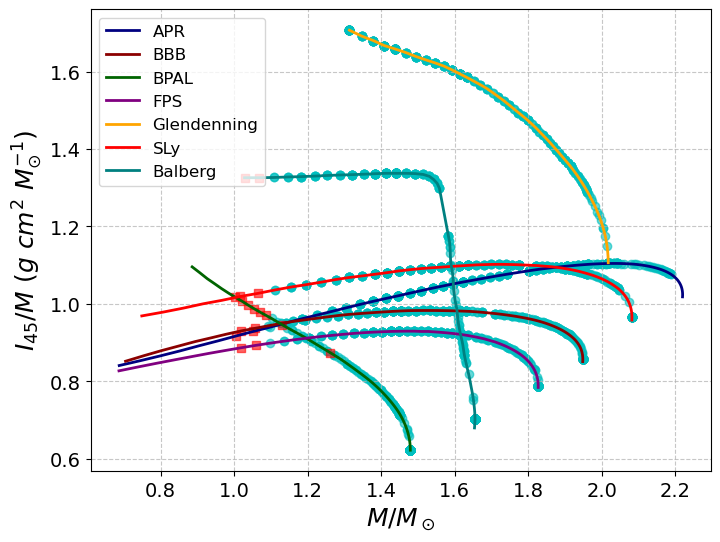

In [11]:
# -------------------------------------------------------------------------------------------------
eos_names = ["akmalpr", 'bbb2', 'bpal12', 'fps', 'glendnh3', 'sly4', 'balbn1h1']
colors = ["navy", "darkred", "darkgreen", "purple", "orange", "red", "teal"]
cols = ['M', 'R', 'C', 'k2', 'l', 'L', 'I']  # Column names
mass50 = []  # Stores masses for 50% probability bound
mass90 = []  # Stores masses for 90% probability bound

for i, eos_name in enumerate(eos_names):
    df = pd.read_csv(f'../output_eos/{eos_name}/MoIL.dat', names=cols)

    # Find index of maximum mass and truncate data
    max_mass_idx = df['M'].idxmax()
    df = df.iloc[:max_mass_idx + 1]

    # Extract mass values for GW170817 constraints
    for j in range(len(df.M)):
        if df.L[j] <= 940.45:  # 50% Probability
            mass50.append(df.M[j])
        elif 940.45 < df.L[j] <= 1913.8:  # 90% Probability
            mass90.append(df.M[j])

# Convert lists to numpy arrays
mass50 = np.array(mass50)
mass90 = np.array(mass90)
###################################################################################################

# Base directory for EOS files
# Base directory for EOS files
lorene_directory = "/home/sanjana/ashoka/thesis/lorene_stuff/"

# EOS file mapping for 300Hz neutron stars
eos_files_stationary = {
    "APR": f"{lorene_directory}Nrotstar_(APR100)_(0.06-0.9)_4499Hz_nrot_extracted_data.csv",
    "BBB": f"{lorene_directory}Nrotstar_(BBB100)_(0.05-0.8)_4499Hz_nrot_extracted_data.csv",
    "BPAL": f"{lorene_directory}Nrotstar_(BPAL100)_(0.06-0.6)_4499Hz_nrot_extracted_data.csv",
    "FPS": f"{lorene_directory}Nrotstar_(FPS100)_(0.04-0.9)_4499Hz_nrot_extracted_data.csv",
    "Glendenning": f"{lorene_directory}Nrotstar_(Glendenning100)_(0.06-0.68)_4499Hz_nrot_extracted_data.csv",
    "SLy": f"{lorene_directory}Nrotstar_(SLy100)_(0.04-0.9)_4499Hz_nrot_extracted_data.csv",
    "Balberg": f"{lorene_directory}Nrotstar_(Balberg100)_(0.08-0.7)_4499Hz_nrot_extracted_data.csv"
}

# Column names for the CSV files
cols = ["Gravitational mass", "Moment of inertia"]

# Dictionaries to store results
mass50_nearest = {}
mass90_nearest = {}
moi50_nearest = {}
moi90_nearest = {}

plt.figure(figsize=(8, 6))

# Loop through each EOS file
for eos, file in eos_files_stationary.items():
    if not os.path.exists(file):
        print(f"Warning: File not found for {eos}: {file}")
        continue  # Skip missing files

    # Read the required columns
    df = pd.read_csv(file, usecols=cols).dropna()

    # Truncate data after max mass
    max_mass_idx = df["Gravitational mass"].idxmax()
    df = df.iloc[:max_mass_idx + 1]

    # Get color for the current EOS
    color = colors[list(eos_files_stationary.keys()).index(eos)]  # Matching EOS to color list
    
    plt.plot(df["Gravitational mass"], df["Moment of inertia"]/df["Gravitational mass"], 
             linestyle="-", color=color, linewidth=2, label=eos)

    # Extract mass and MoI values
    mass_values = df["Gravitational mass"].values
    moi_values = df["Moment of inertia"].values / mass_values

    # Find the nearest mass values for mass50 and mass90
    nearest_mass50 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass50]
    nearest_mass90 = [mass_values[np.abs(mass_values - m).argmin()] for m in mass90]
    nearest_mass90 = np.array(list(set(nearest_mass90) - set(nearest_mass50)))

    # Find the corresponding MoI values
    corresponding_moi50 = [moi_values[np.abs(mass_values - m).argmin()] for m in nearest_mass50]
    corresponding_moi90 = [moi_values[np.abs(mass_values - m).argmin()] for m in nearest_mass90]

    # Store results
    mass50_nearest[eos] = np.array(nearest_mass50)
    mass90_nearest[eos] = np.array(nearest_mass90)
    moi50_nearest[eos] = np.array(corresponding_moi50)
    moi90_nearest[eos] = np.array(corresponding_moi90)

# --- Plotting MoI vs Mass for 50% and 90% Probability ---

for eos in eos_files_stationary.keys():
    if eos in mass50_nearest and eos in moi50_nearest:
        plt.scatter(mass50_nearest[eos], moi50_nearest[eos], color="c", marker="o", alpha=0.6)
    
    if eos in mass90_nearest and eos in moi90_nearest:
        plt.scatter(mass90_nearest[eos], moi90_nearest[eos], color="r", marker="s", alpha=0.6)

plt.xlabel(r'$M/M_\odot$', fontsize=18)
plt.ylabel(r'$I_{45}/M \ (g \ cm^2 \ M_{\odot}^{-1})$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.savefig("MOI_with_constraints_high_rot.png", dpi=300)
plt.show()